<a href="https://colab.research.google.com/github/Ciss48/Pixon/blob/main/Crazy_Coffee_Level_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

In [ ]:
from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Đánh giá level

In [ ]:
start_date = '2025-09-04'
end_date = '2025-09-14'
version = '1.1.27'
# version_list = ['1.0.23','1.0.21']
# version = "', '".join(version_list)

In [ ]:
# Winrate vs
query1 = f"""
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  where event_date between '{start_date}' and '{end_date}'
  and version in ('{version}')
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  GROUP BY  level
),
  booster_use as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_booster_use
    FROM `crazy-coffee-jam.flatten_table.booster_use`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
    GROUP BY  level
  ),
  ad_reward as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_ad_reward
    FROM `crazy-coffee-jam.flatten_table.af_rewarded`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
    GROUP BY  level
  ),
ad_inter_attemp as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_inter_attemp
  FROM `crazy-coffee-jam.flatten_table.af_inter_attempt`
    where event_date between '{start_date}' and '{end_date}'
    and version in ('{version}')
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  GROUP BY  level
)
SELECT
  safe_cast(s.level as int) as level,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose,
  COALESCE(r.event_revive, 0) as event_revive,
  COALESCE(b.num_booster_use, 0) as num_booster_use,
  COALESCE(a.num_ad_reward, 0) as num_ad_reward,
  COALESCE(ia.num_ad_inter_attemp, 0) as num_ad_inter_attemp,
  s.user_start,
  w.user_win,
  l.user_lose,
  r.user_revive
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN ad_inter_attemp ia
  ON s.level = ia.level;
"""
winrate = client.query(query1).to_dataframe()

winrate

level  event_start  event_win  event_lose  event_revive  num_booster_use  \
0      261           60         58           2             1                1   
1      260          115         58          32            96              109   
2      254           64         59           0             8               23   
3      253           61         59           1             3                2   
4      257           59         59           0             0                0   
..     ...          ...        ...         ...           ...              ...   
737    657            4          4           0             0                0   
738    653            4          4           0             0                0   
739    651            4          4           0             0                0   
740    647            5          4           0             0                0   
741    658            4          4           0             1                1   

     num_ad_reward  num_ad_inter_attemp  user_start  user_win  user_lose  \
0                4                    0          58        58          2   
1               62                    0          58        58         15   
2               10                    0          59        59       <NA>   
3                3                    0          59        59          1   
4                1                    0          59        59       <NA>   
..             ...                  ...         ...       ...        ...   
737              0                    0           4         4       <NA>   
738              0                    0           4         4       <NA>   
739              0                    0           4         4       <NA>   
740              0                    0           4         4       <NA>   
741              2                    0           4         4       <NA>   

     user_revive  
0              1  
1             38  
2              5  
3              3  
4           <NA>  
..           ...  
737         <NA>  
738         <NA>  
739         <NA>  
740         <NA>  
741            1  

[742 rows x 12 columns]

In [ ]:
# Điền các giá trị 0 vào các ô NA
winrate = winrate.fillna(0)
# sort
winrate = winrate.sort_values('level', ascending=True)
# ad_inter = 0 vào 1,2,3,4
winrate.loc[winrate['level'].isin([1, 2, 3, 4]), 'num_ad_inter_attemp'] = 0

# tạo df chứa app_remove và arpu by level
query = f"""
with a as (
select level, sum(total_revenue) as total_revenue
from `crazy-coffee-jam.dashboard_table.arpu_level`
where event_date between '{start_date}' and '{end_date}'
and version in ('{version}')
group by level
), b as (
select level, sum(num_user_remove) as num_user_remove
from `crazy-coffee-jam.dashboard_table.remove_by_level`
where event_date between '{start_date}' and '{end_date}'
and version in ('{version}')
group by level
)
select a.level, a.total_revenue, b.num_user_remove
from a left join b on a.level = b.level;
"""
arpu_remove = client.query(query).to_dataframe()
arpu_remove = arpu_remove.fillna(0)
arpu_remove = arpu_remove.sort_values('level', ascending=True)

# Nối 2 df qua level
df = winrate.merge(arpu_remove, on='level', how='left')
df


level  event_start  event_win  event_lose  event_revive  num_booster_use  \
0        1        10442      10337           0             0                0   
1        2        10321      10285           0             0                0   
2        3        10260      10244           1             0                0   
3        4        10239      10168           0             0                0   
4        5        10255      10011           0             0                0   
..     ...          ...        ...         ...           ...              ...   
737    738            2          2           0             1                1   
738    739            2          2           0             2                0   
739    740            7          1           5             3                3   
740    741            1          1           0             0                0   
741    742            1          1           0             0                0   

     num_ad_reward  num_ad_inter_attemp  user_start  user_win  user_lose  \
0               30                    0       10381     10298          0   
1               32                    0       10289     10247          0   
2               31                    0       10234     10206          1   
3               26                    0       10194     10128          0   
4               25                    0       10114      9959          0   
..             ...                  ...         ...       ...        ...   
737              1                    0           2         2          0   
738              0                    0           2         2          0   
739              6                    0           2         1          1   
740              0                    0           1         1          0   
741              0                    0           1         1          0   

     user_revive  total_revenue  num_user_remove  
0              0       3.649351                0  
1              0      18.572448                0  
2              0       1.507835                0  
3              0       3.085189                0  
4              0       7.932541                0  
..           ...            ...              ...  
737            1       1.188414                0  
738            1       1.111685                0  
739            1      12.549331                0  
740            0       0.380179                0  
741            0       0.804896                0  

[742 rows x 14 columns]

In [ ]:
# Transform and add column
# Add next level's user_start count
df['user_start_next_level'] = df['user_start'].shift(-1)

# Calculate drop rate
df['drop_user'] = 1 - (df['user_start_next_level'] / df['user_start'])

# Calculate winrate
df['winrate'] = df['event_win'] / (df['event_win'] + df['event_lose'] + df['event_revive'])

# Convert winrate and drop_user to percentages
df['winrate'] = df['winrate'] * 100
df['drop_user'] = df['drop_user'] * 100

df['booster_per_user'] = df['num_booster_use'] / df['user_start']
df['ad_reward_per_user'] = df['num_ad_reward'] / df['user_start']

df['arpu'] = df['total_revenue'] / df['user_start']
df['remove_rate'] = df['num_user_remove'] / df['user_start'] * 100

df['ad_inter_attemp_per_user'] = df['num_ad_inter_attemp'] / df['user_start']

### Winrate vs Booster/ Ad reward

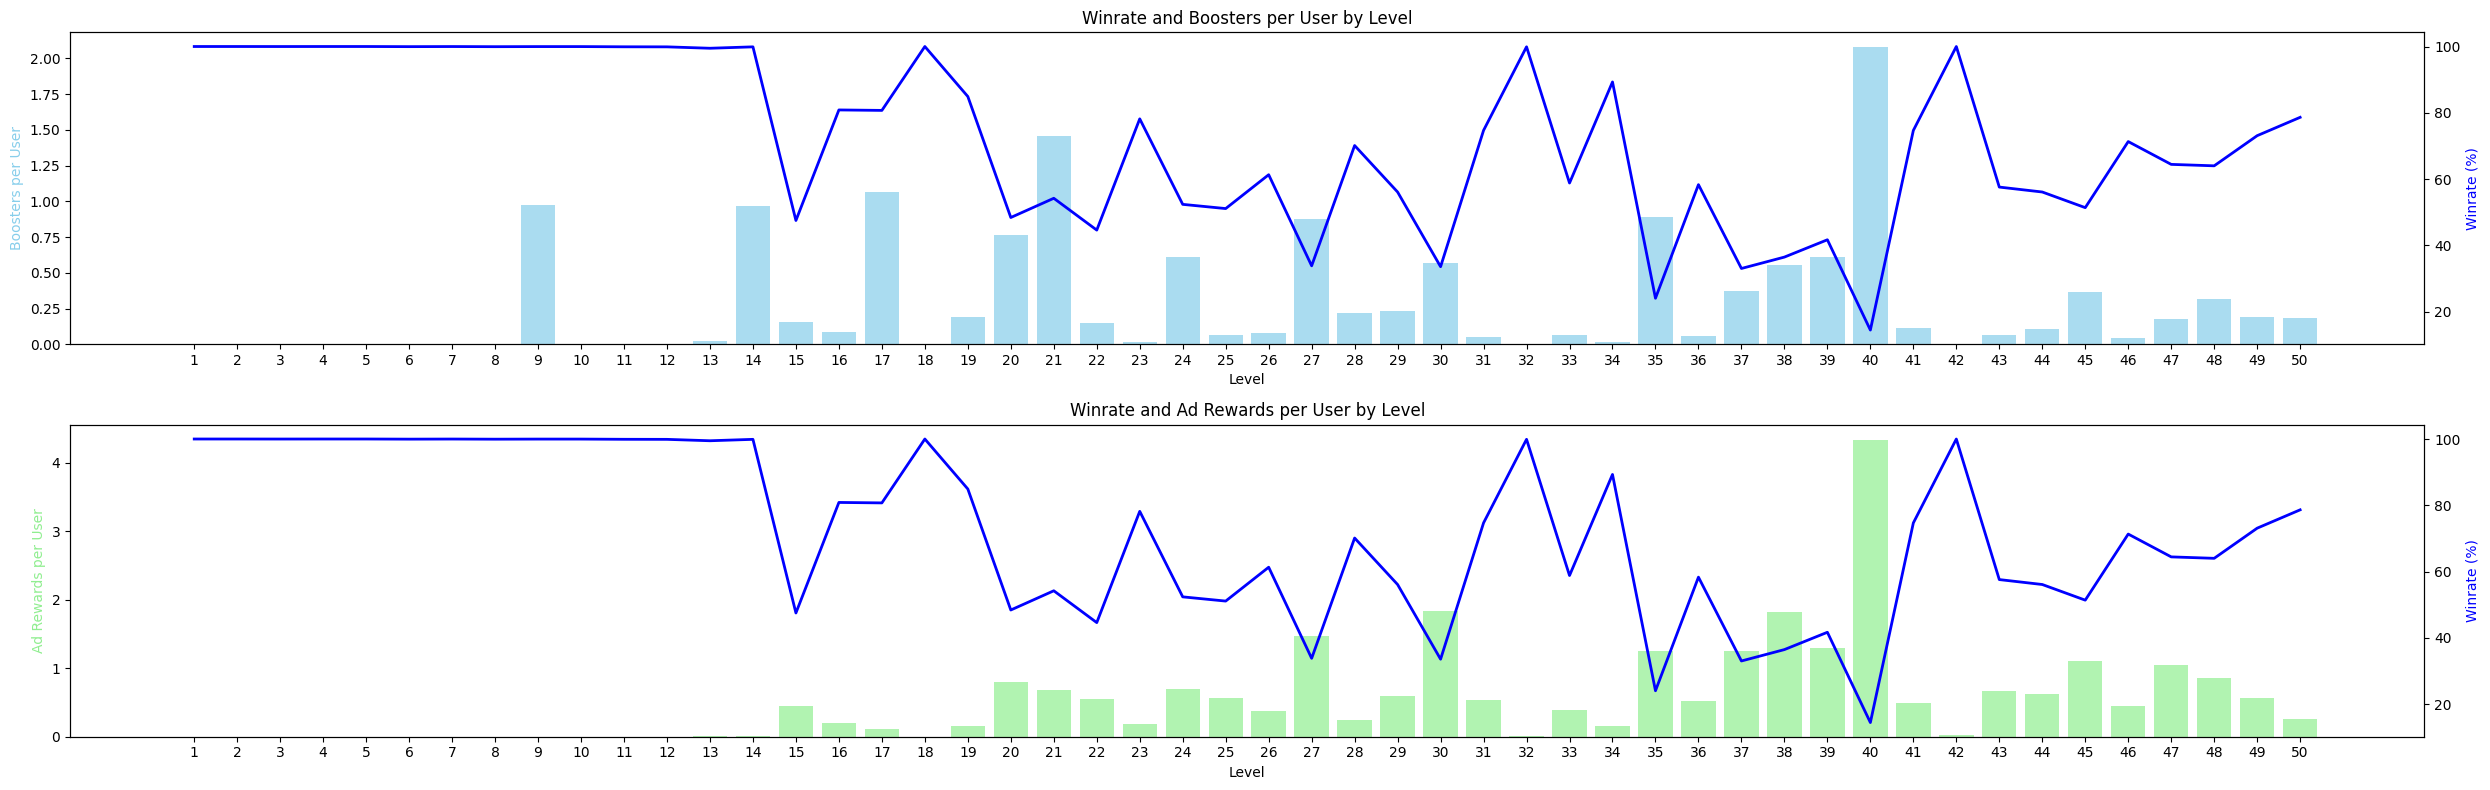

In [ ]:
# Filter for levels <= 100
df1 = df[df['level'] <= 50]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8))

# First subplot - winrate and booster_per_user
ax1_twin = ax1.twinx()
ax1.bar(df1['level'], df1['booster_per_user'], color='skyblue', alpha=0.7)
ax1_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)

ax1.set_xlabel('Level')
ax1.set_ylabel('Boosters per User', color='skyblue')
ax1_twin.set_ylabel('Winrate (%)', color='blue')
ax1.set_title('Winrate and Boosters per User by Level')

# Set x-axis ticks to show all levels
ax1.set_xticks(df1['level'])

# Second subplot - winrate and ad_reward_per_user
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['ad_reward_per_user'], color='lightgreen', alpha=0.7)
ax2_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)

ax2.set_xlabel('Level')
ax2.set_ylabel('Ad Rewards per User', color='lightgreen')
ax2_twin.set_ylabel('Winrate (%)', color='blue')
ax2.set_title('Winrate and Ad Rewards per User by Level')

# Set x-axis ticks to show all levels
ax2.set_xticks(df1['level'])

plt.tight_layout()
plt.show()

### Drop vs winrate/Arpu

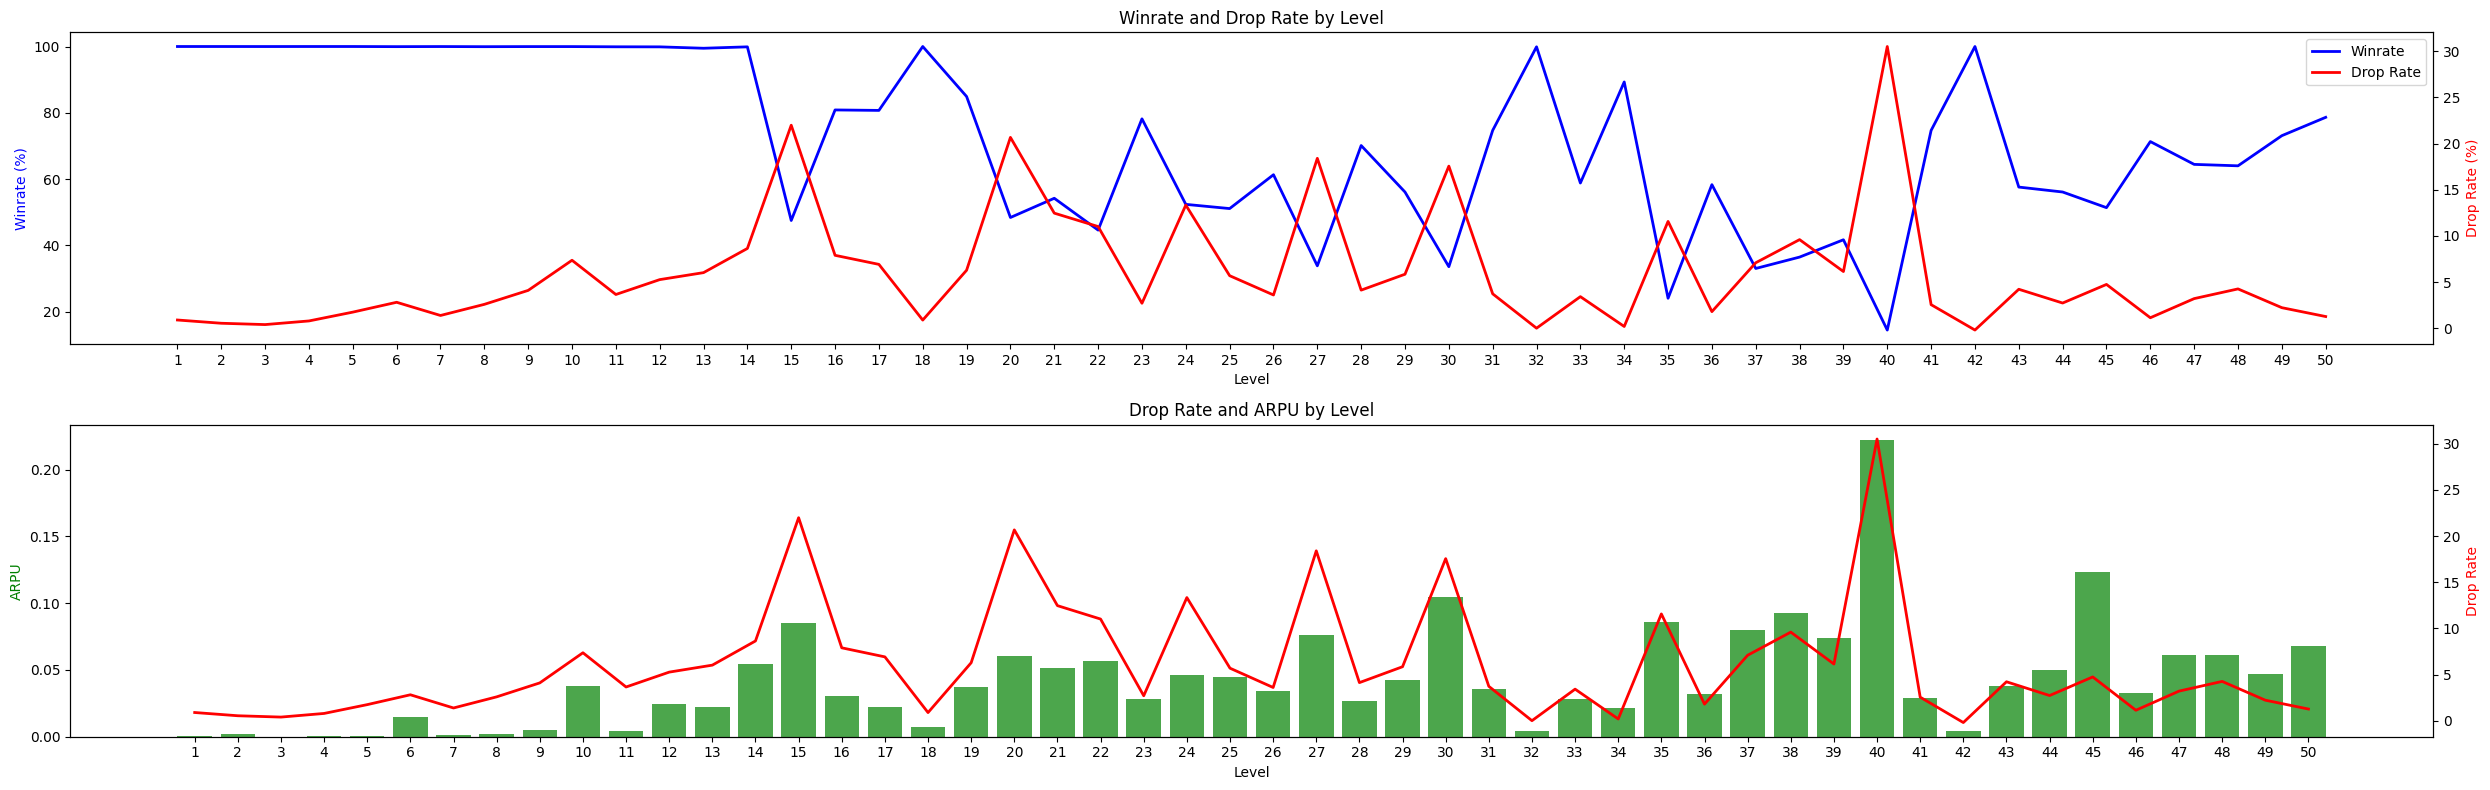

In [ ]:
# Filter for levels <= 100
df1 = df[df['level'] <= 50]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8))

# First subplot - winrate and drop rate
ax1_twin = ax1.twinx()
ax1.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax1_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2, label='Drop Rate')

ax1.set_xlabel('Level')
ax1.set_ylabel('Winrate (%)', color='blue')
ax1_twin.set_ylabel('Drop Rate (%)', color='red')
ax1.set_title('Winrate and Drop Rate by Level')

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

# Set x-axis ticks to show all levels
ax1.set_xticks(df1['level'])

# Second subplot - drop rate and ARPU
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['arpu'], color='green', alpha=0.7)
ax2_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)

ax2.set_xlabel('Level')
ax2.set_ylabel('ARPU', color='green')
ax2_twin.set_ylabel('Drop Rate', color='red')
ax2.set_title('Drop Rate and ARPU by Level')

# Set x-axis ticks to show all levels
ax2.set_xticks(df1['level'])

plt.tight_layout()
plt.show()

### Drop rate vs Winrater/Ads_inter

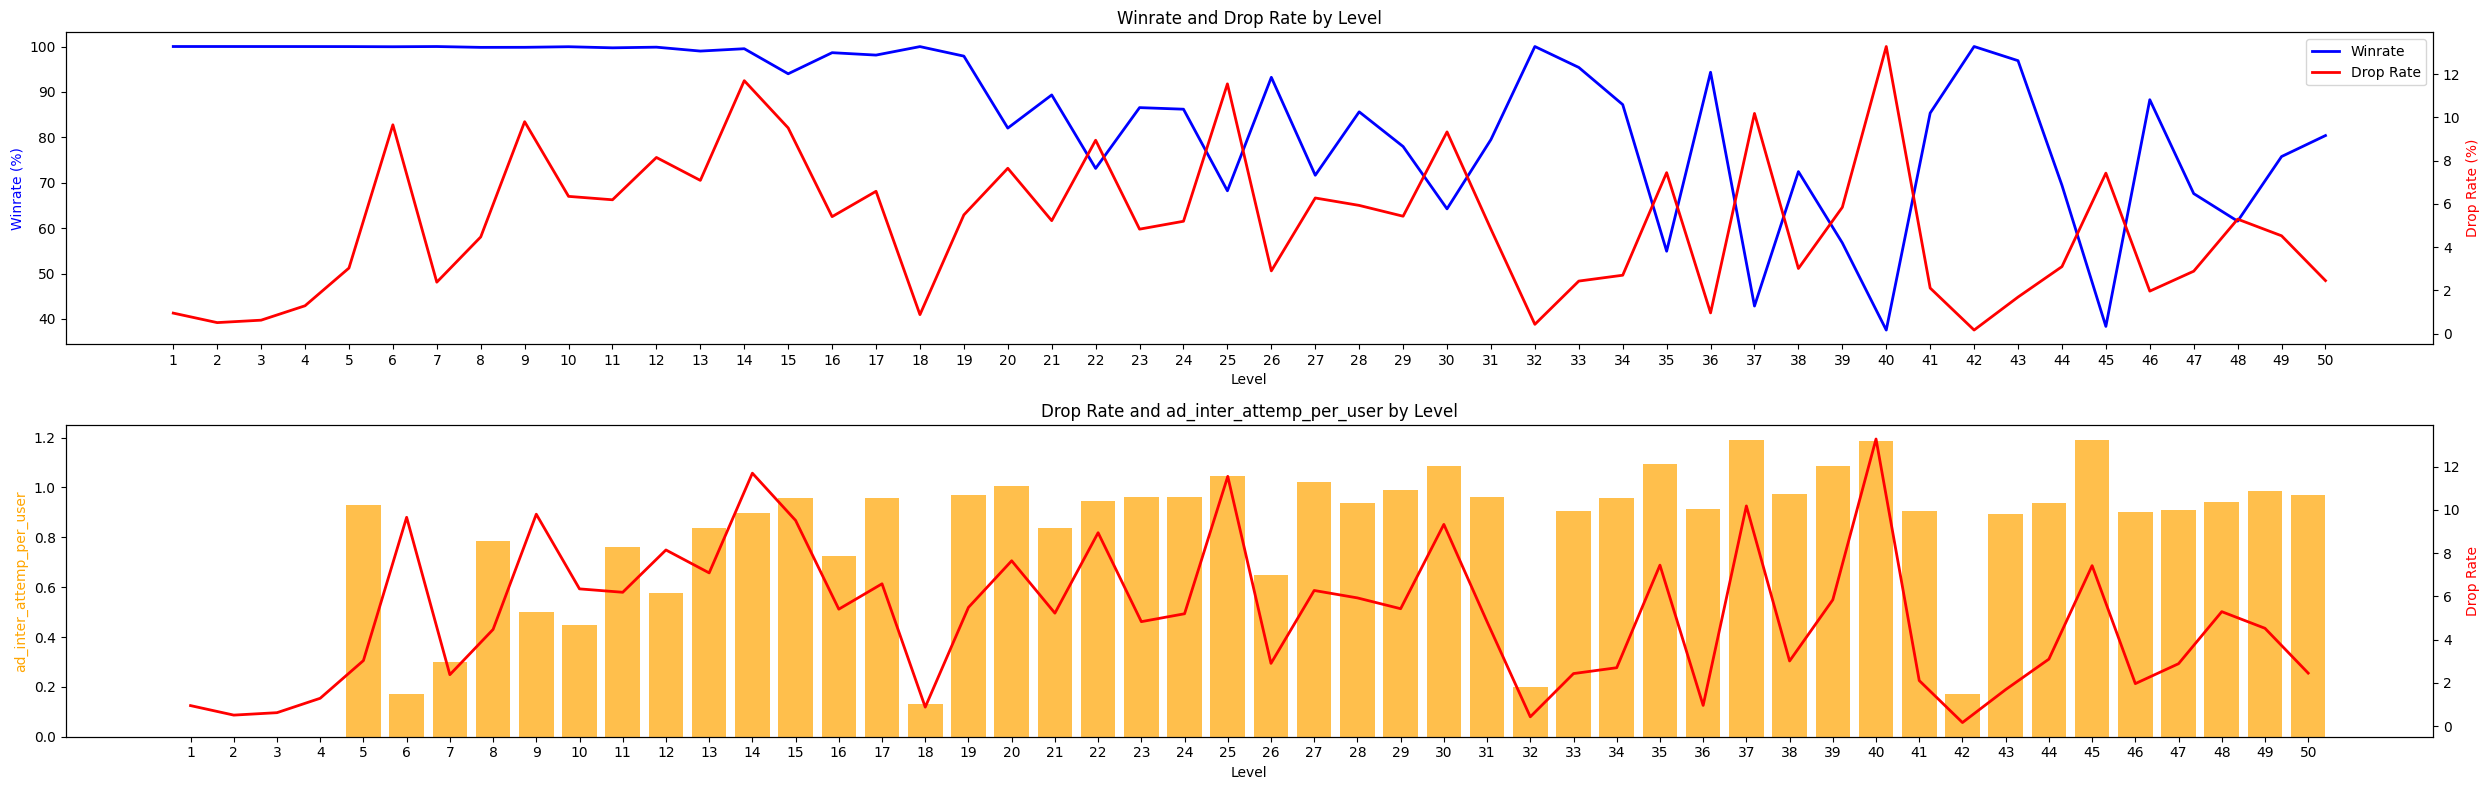

In [ ]:
# Filter for levels <= 100
df1 = df[df['level'] <= 50]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8))

# First subplot - winrate and drop rate
ax1_twin = ax1.twinx()
ax1.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax1_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2, label='Drop Rate')

ax1.set_xlabel('Level')
ax1.set_ylabel('Winrate (%)', color='blue')
ax1_twin.set_ylabel('Drop Rate (%)', color='red')
ax1.set_title('Winrate and Drop Rate by Level')

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

# Set x-axis ticks to show all levels
ax1.set_xticks(df1['level'])

# Second subplot - drop rate and ARPU
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['ad_inter_attemp_per_user'], color='orange', alpha=0.7)
ax2_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)

ax2.set_xlabel('Level')
ax2.set_ylabel('ad_inter_attemp_per_user', color='orange')
ax2_twin.set_ylabel('Drop Rate', color='red')
ax2.set_title('Drop Rate and ad_inter_attemp_per_user by Level')

# Set x-axis ticks to show all levels
ax2.set_xticks(df1['level'])

plt.tight_layout()
plt.show()

### Remove rate vs Winrate/Arpu

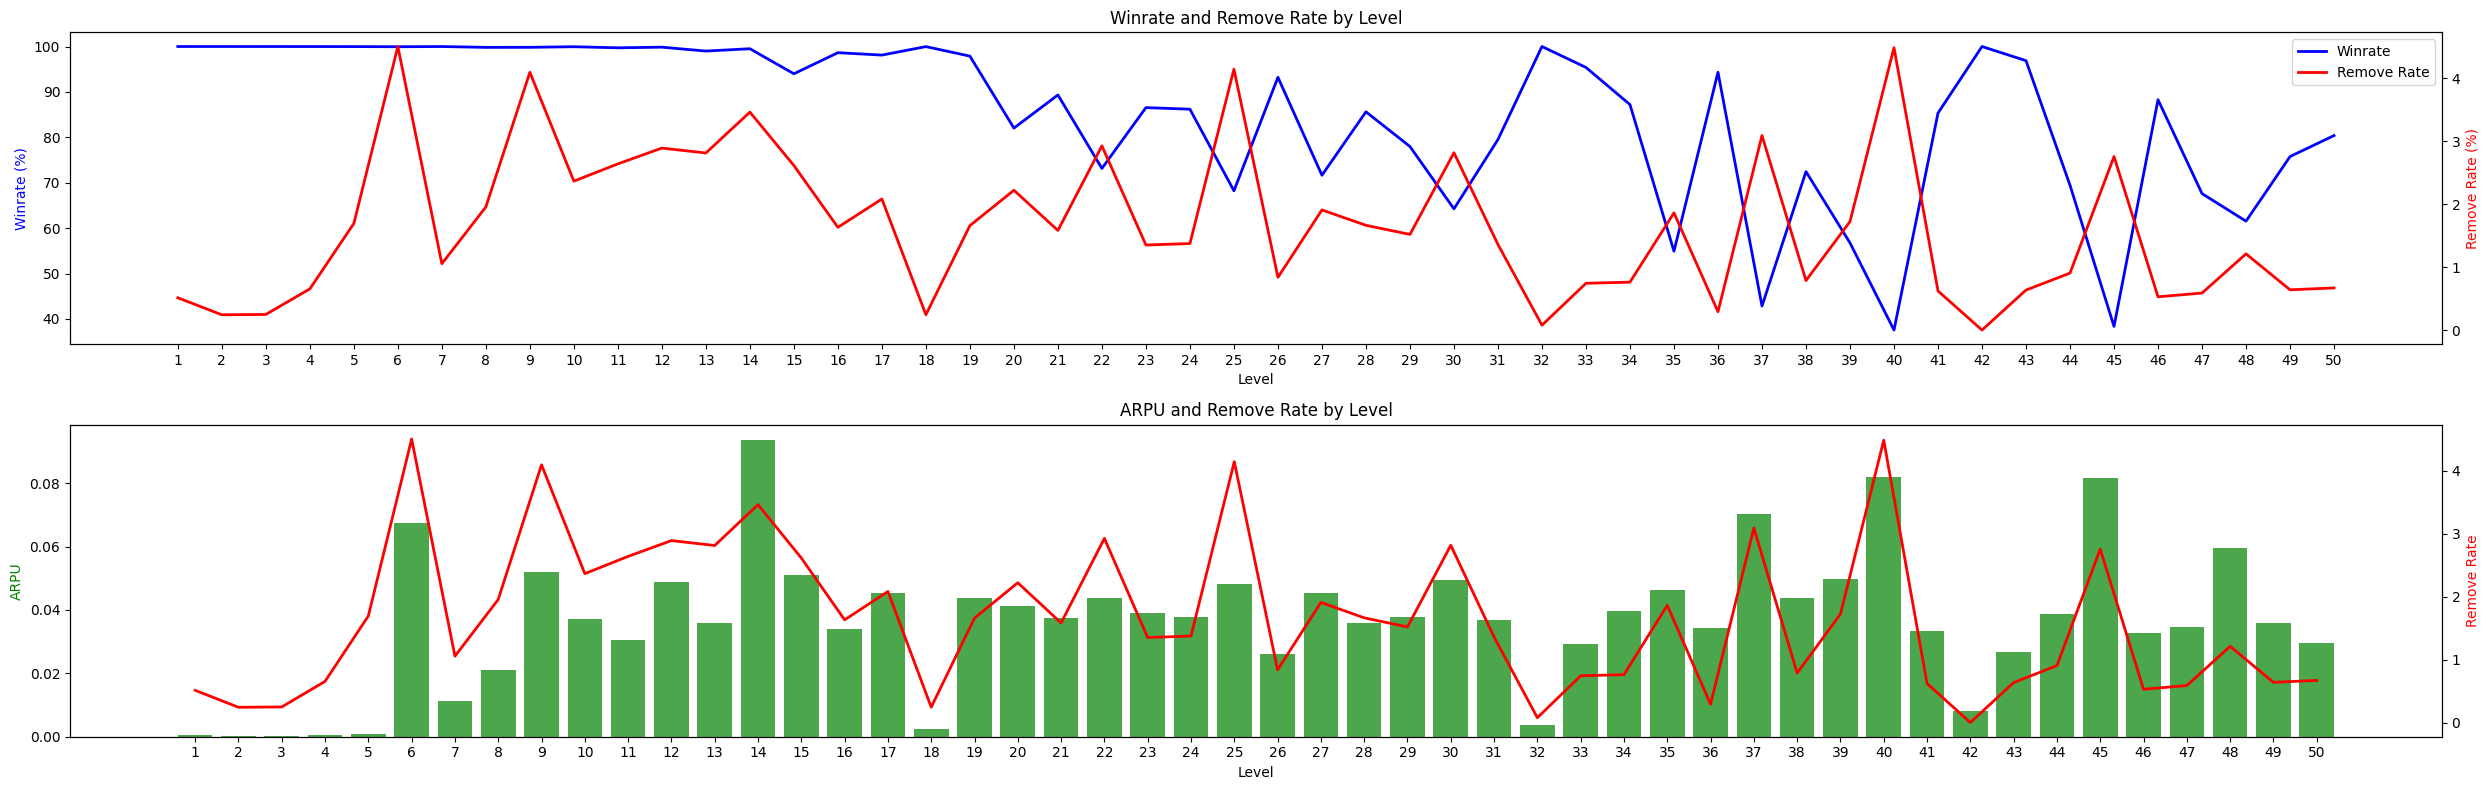

In [ ]:
# Filter for levels <= 100
df1 = df[df['level'] <= 50]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8))

# First subplot - winrate and remove rate
ax1_twin = ax1.twinx()
ax1.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax1_twin.plot(df1['level'], df1['remove_rate'], color='red', linewidth=2, label='Remove Rate')

ax1.set_xlabel('Level')
ax1.set_ylabel('Winrate (%)', color='blue')
ax1_twin.set_ylabel('Remove Rate (%)', color='red')
ax1.set_title('Winrate and Remove Rate by Level')

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

# Set x-axis ticks to show all levels
ax1.set_xticks(df1['level'])

# Second subplot - drop rate and ARPU
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['arpu'], color='green', alpha=0.7)
ax2_twin.plot(df1['level'], df1['remove_rate'], color='red', linewidth=2)

ax2.set_xlabel('Level')
ax2.set_ylabel('ARPU', color='green')
ax2_twin.set_ylabel('Remove Rate', color='red')
ax2.set_title('ARPU and Remove Rate by Level')

# Set x-axis ticks to show all levels
ax2.set_xticks(df1['level'])

plt.tight_layout()
plt.show()

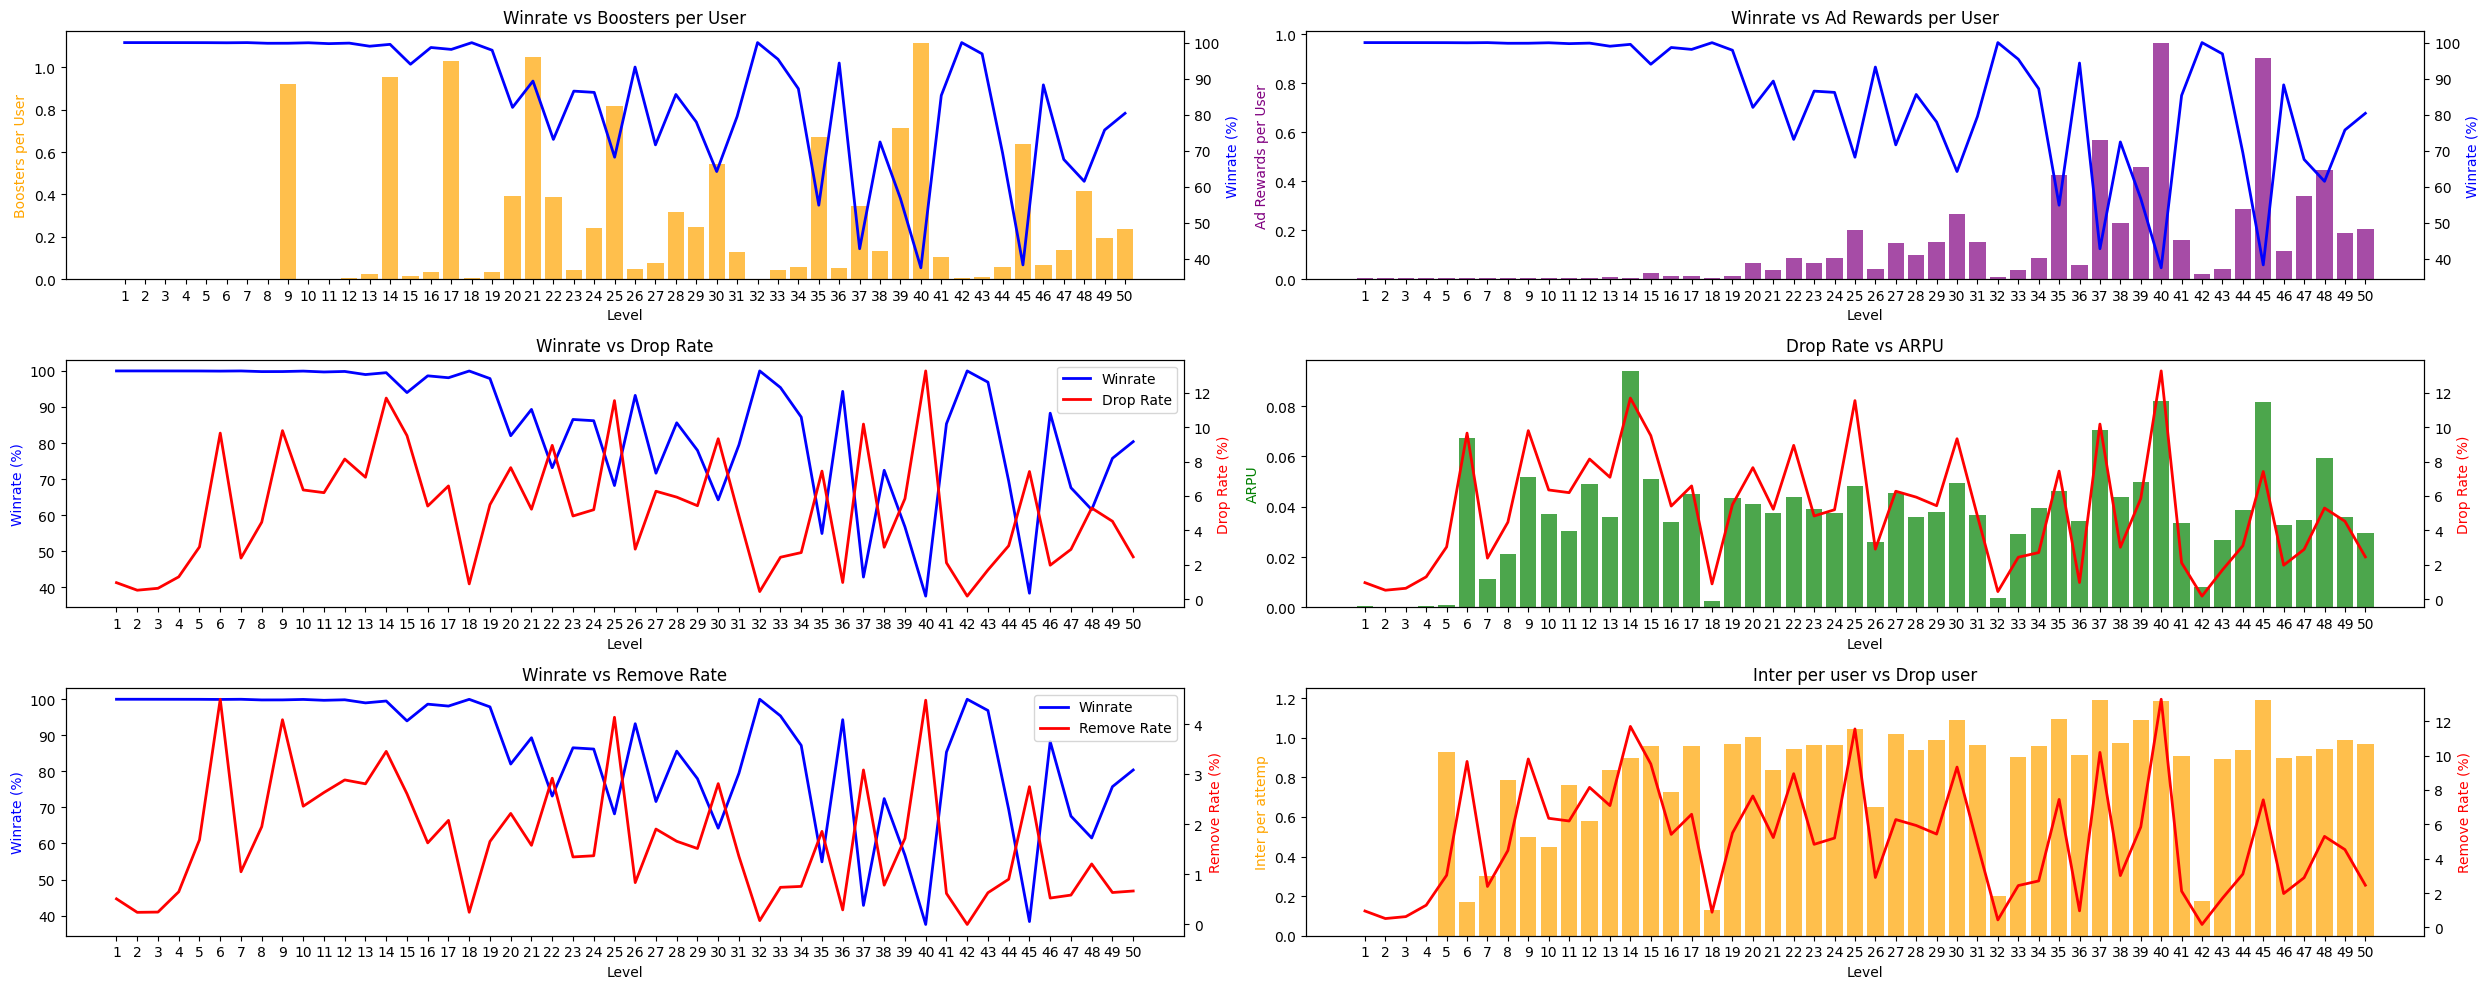

In [ ]:
# Create figure with 6 subplots (3 rows, 2 columns)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 10))

# 1st row, 1st column: winrate vs booster_per_user
ax1_twin = ax1.twinx()
ax1.bar(df1['level'], df1['booster_per_user'], color='orange', alpha=0.7)
ax1_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)
ax1.set_xlabel('Level')
ax1.set_ylabel('Boosters per User', color='orange')
ax1_twin.set_ylabel('Winrate (%)', color='blue')
ax1.set_title('Winrate vs Boosters per User')
ax1.set_xticks(df1['level'])

# 1st row, 2nd column: winrate vs ad_reward_per_user
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['ad_reward_per_user'], color='purple', alpha=0.7)
ax2_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)
ax2.set_xlabel('Level')
ax2.set_ylabel('Ad Rewards per User', color='purple')
ax2_twin.set_ylabel('Winrate (%)', color='blue')
ax2.set_title('Winrate vs Ad Rewards per User')
ax2.set_xticks(df1['level'])

# 2nd row, 1st column: winrate vs drop_user
ax3_twin = ax3.twinx()
ax3.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax3_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2, label='Drop Rate')
ax3.set_xlabel('Level')
ax3.set_ylabel('Winrate (%)', color='blue')
ax3_twin.set_ylabel('Drop Rate (%)', color='red')
ax3.set_title('Winrate vs Drop Rate')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2)
ax3.set_xticks(df1['level'])

# 2nd row, 2nd column: drop_user vs arpu
ax4_twin = ax4.twinx()
ax4.bar(df1['level'], df1['arpu'], color='green', alpha=0.7)
ax4_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)
ax4.set_xlabel('Level')
ax4.set_ylabel('ARPU', color='green')
ax4_twin.set_ylabel('Drop Rate (%)', color='red')
ax4.set_title('Drop Rate vs ARPU')
ax4.set_xticks(df1['level'])

# 3rd row, 1st column: winrate vs remove_rate
ax5_twin = ax5.twinx()
ax5.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax5_twin.plot(df1['level'], df1['remove_rate'], color='red', linewidth=2, label='Remove Rate')
ax5.set_xlabel('Level')
ax5.set_ylabel('Winrate (%)', color='blue')
ax5_twin.set_ylabel('Remove Rate (%)', color='red')
ax5.set_title('Winrate vs Remove Rate')
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2)
ax5.set_xticks(df1['level'])

# 3rd row, 2nd column: remove_rate vs arpu
ax6_twin = ax6.twinx()
ax6.bar(df1['level'], df1['ad_inter_attemp_per_user'], color='orange', alpha=0.7)
ax6_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)
ax6.set_xlabel('Level')
ax6.set_ylabel('Inter per attemp', color='orange')
ax6_twin.set_ylabel('Remove Rate (%)', color='red')
ax6.set_title('Inter per user vs Drop user')
ax6.set_xticks(df1['level'])

# Adjust layout and display
plt.tight_layout()
plt.show()

### Compare version

#### Ver 1.1.16

In [ ]:
start_date = '2025-06-20'
end_date = '2025-07-10'
version = '1.1.16'

In [ ]:
# Winrate vs
query1 = f"""
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
  booster_use as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_booster_use
    FROM `crazy-coffee-jam.flatten_table.booster_use`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
    GROUP BY  level
  ),
  ad_reward as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_ad_reward
    FROM `crazy-coffee-jam.flatten_table.af_rewarded`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
    GROUP BY  level
  ),
ad_inter_attemp as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_inter_attemp
  FROM `crazy-coffee-jam.flatten_table.af_inter_attempt`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
)
SELECT
  safe_cast(s.level as int) as level,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose,
  COALESCE(r.event_revive, 0) as event_revive,
  COALESCE(b.num_booster_use, 0) as num_booster_use,
  COALESCE(a.num_ad_reward, 0) as num_ad_reward,
  COALESCE(ia.num_ad_inter_attemp, 0) as num_ad_inter_attemp,
  s.user_start,
  w.user_win,
  l.user_lose,
  r.user_revive
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN ad_inter_attemp ia
  ON s.level = ia.level;
"""
winrate = client.query(query1).to_dataframe()
# Điền các giá trị 0 vào các ô NA
winrate = winrate.fillna(0)
# sort
winrate = winrate.sort_values('level', ascending=True)
# ad_inter = 0 vào 1,2,3,4
winrate.loc[winrate['level'].isin([1, 2, 3, 4]), 'num_ad_inter_attemp'] = 0

# tạo df chứa app_remove và arpu by level
query = f"""
with a as (
select level, sum(total_revenue) as total_revenue
from `crazy-coffee-jam.dashboard_table.arpu_level`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
group by level
), b as (
select level, sum(num_user_remove) as num_user_remove
from `crazy-coffee-jam.dashboard_table.remove_by_level`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
group by level
)
select a.level, a.total_revenue, b.num_user_remove
from a left join b on a.level = b.level;
"""
arpu_remove = client.query(query).to_dataframe()
arpu_remove = arpu_remove.fillna(0)
arpu_remove = arpu_remove.sort_values('level', ascending=True)

# Nối 2 df qua level
df = winrate.merge(arpu_remove, on='level', how='left')

# Transform and add column
# Add next level's user_start count
df['user_start_next_level'] = df['user_start'].shift(-1)

# Calculate drop rate
df['drop_user'] = 1 - (df['user_start_next_level'] / df['user_start'])

# Calculate winrate
df['winrate'] = df['event_win'] / (df['event_win'] + df['event_lose'] + df['event_revive'])

# Convert winrate and drop_user to percentages
df['winrate'] = df['winrate'] * 100
df['drop_user'] = df['drop_user'] * 100

df['booster_per_user'] = df['num_booster_use'] / df['user_start']
df['ad_reward_per_user'] = df['num_ad_reward'] / df['user_start']

df['arpu'] = df['total_revenue'] / df['user_start']
df['remove_rate'] = df['num_user_remove'] / df['user_start'] * 100

df['ad_inter_attemp_per_user'] = df['num_ad_inter_attemp'] / df['user_start']

df1 = df[df['level'] <= 50]

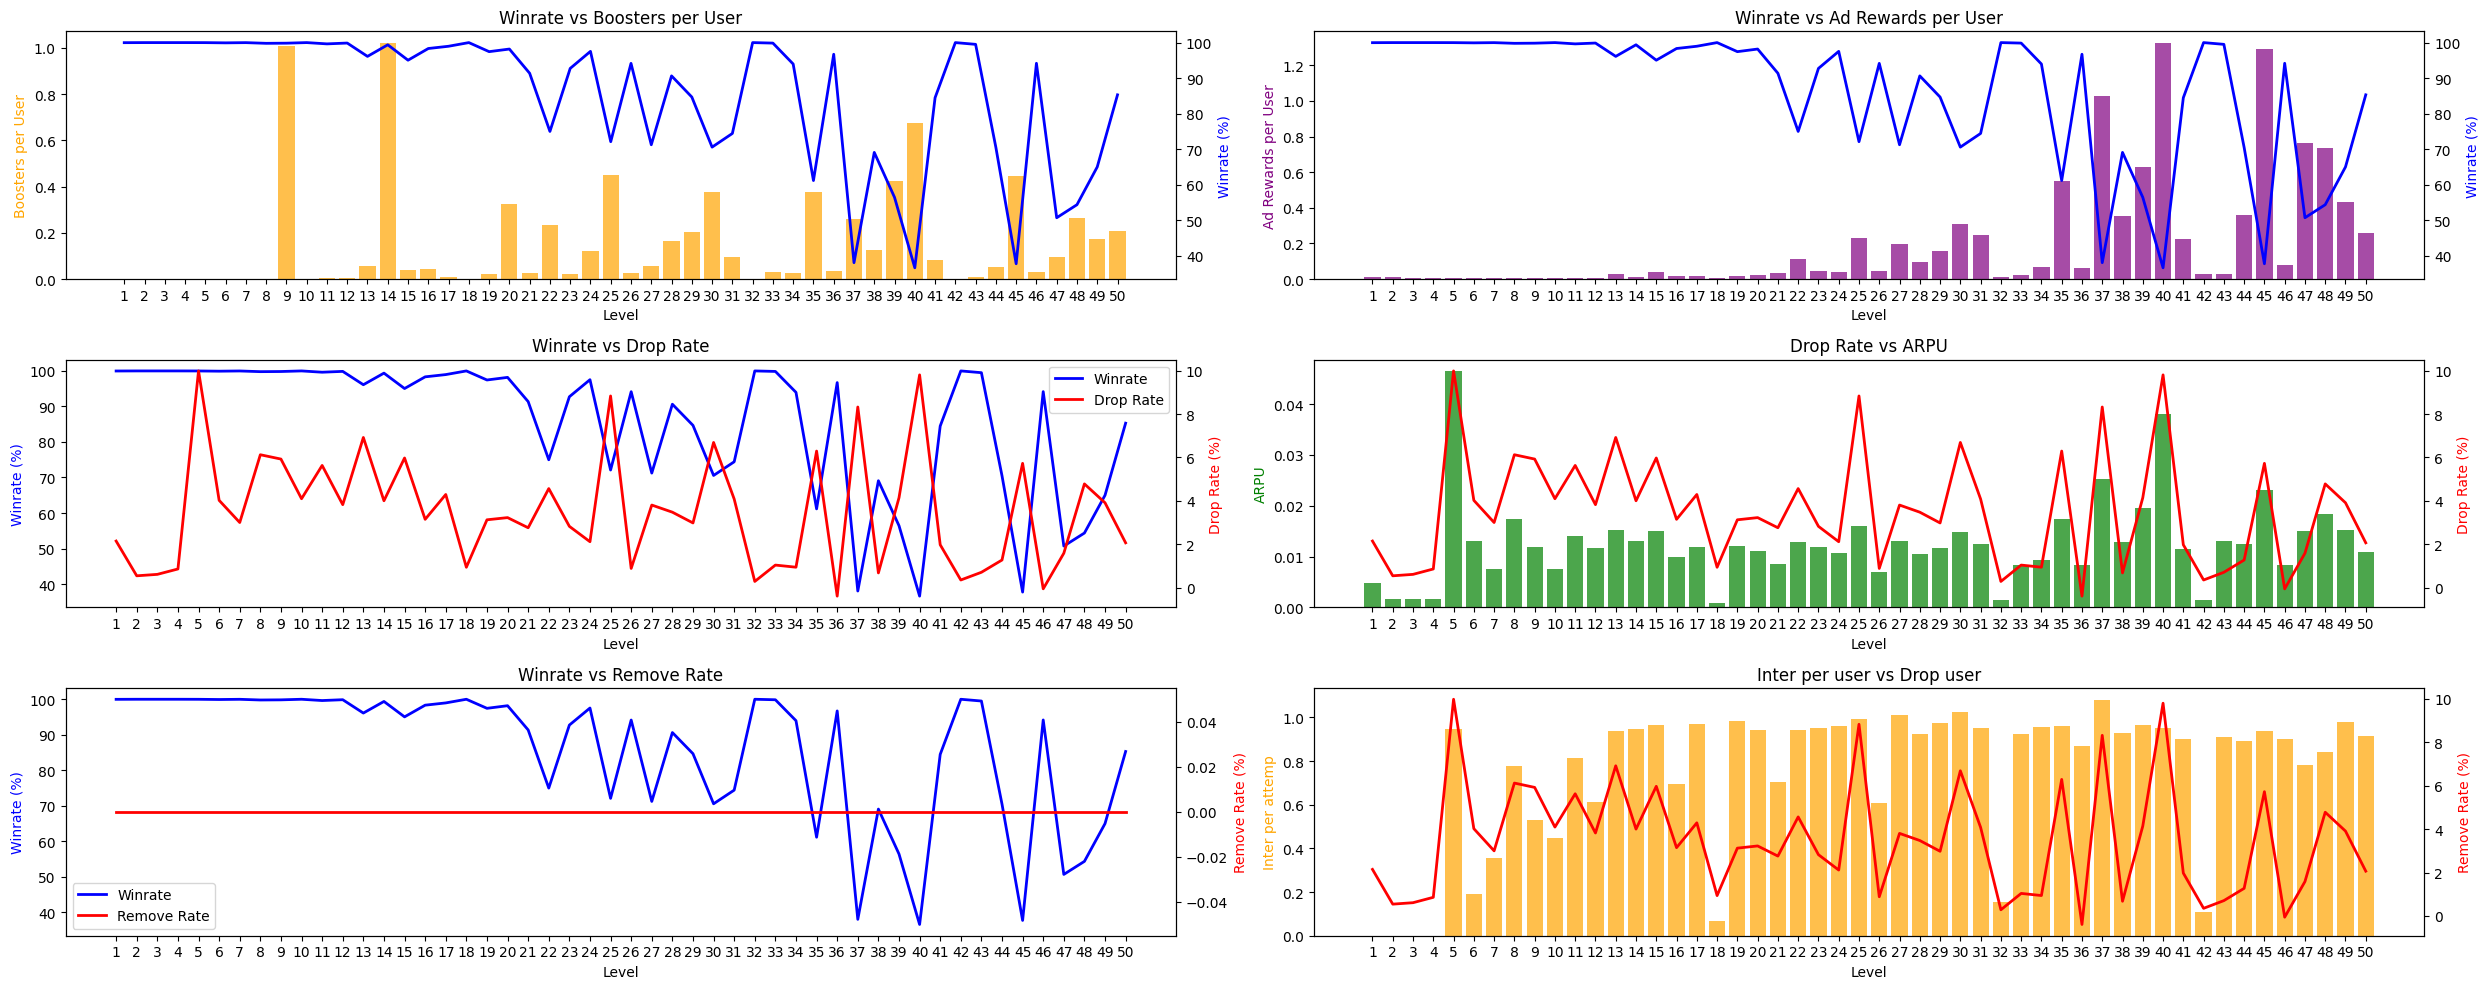

In [ ]:
# Create figure with 6 subplots (3 rows, 2 columns)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 10))

# 1st row, 1st column: winrate vs booster_per_user
ax1_twin = ax1.twinx()
ax1.bar(df1['level'], df1['booster_per_user'], color='orange', alpha=0.7)
ax1_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)
ax1.set_xlabel('Level')
ax1.set_ylabel('Boosters per User', color='orange')
ax1_twin.set_ylabel('Winrate (%)', color='blue')
ax1.set_title('Winrate vs Boosters per User')
ax1.set_xticks(df1['level'])

# 1st row, 2nd column: winrate vs ad_reward_per_user
ax2_twin = ax2.twinx()
ax2.bar(df1['level'], df1['ad_reward_per_user'], color='purple', alpha=0.7)
ax2_twin.plot(df1['level'], df1['winrate'], color='blue', linewidth=2)
ax2.set_xlabel('Level')
ax2.set_ylabel('Ad Rewards per User', color='purple')
ax2_twin.set_ylabel('Winrate (%)', color='blue')
ax2.set_title('Winrate vs Ad Rewards per User')
ax2.set_xticks(df1['level'])

# 2nd row, 1st column: winrate vs drop_user
ax3_twin = ax3.twinx()
ax3.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax3_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2, label='Drop Rate')
ax3.set_xlabel('Level')
ax3.set_ylabel('Winrate (%)', color='blue')
ax3_twin.set_ylabel('Drop Rate (%)', color='red')
ax3.set_title('Winrate vs Drop Rate')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2)
ax3.set_xticks(df1['level'])

# 2nd row, 2nd column: drop_user vs arpu
ax4_twin = ax4.twinx()
ax4.bar(df1['level'], df1['arpu'], color='green', alpha=0.7)
ax4_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)
ax4.set_xlabel('Level')
ax4.set_ylabel('ARPU', color='green')
ax4_twin.set_ylabel('Drop Rate (%)', color='red')
ax4.set_title('Drop Rate vs ARPU')
ax4.set_xticks(df1['level'])

# 3rd row, 1st column: winrate vs remove_rate
ax5_twin = ax5.twinx()
ax5.plot(df1['level'], df1['winrate'], color='blue', linewidth=2, label='Winrate')
ax5_twin.plot(df1['level'], df1['remove_rate'], color='red', linewidth=2, label='Remove Rate')
ax5.set_xlabel('Level')
ax5.set_ylabel('Winrate (%)', color='blue')
ax5_twin.set_ylabel('Remove Rate (%)', color='red')
ax5.set_title('Winrate vs Remove Rate')
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2)
ax5.set_xticks(df1['level'])

# 3rd row, 2nd column: remove_rate vs arpu
ax6_twin = ax6.twinx()
ax6.bar(df1['level'], df1['ad_inter_attemp_per_user'], color='orange', alpha=0.7)
ax6_twin.plot(df1['level'], df1['drop_user'], color='red', linewidth=2)
ax6.set_xlabel('Level')
ax6.set_ylabel('Inter per attemp', color='orange')
ax6_twin.set_ylabel('Remove Rate (%)', color='red')
ax6.set_title('Inter per user vs Drop user')
ax6.set_xticks(df1['level'])

# Adjust layout and display
plt.tight_layout()
plt.show()

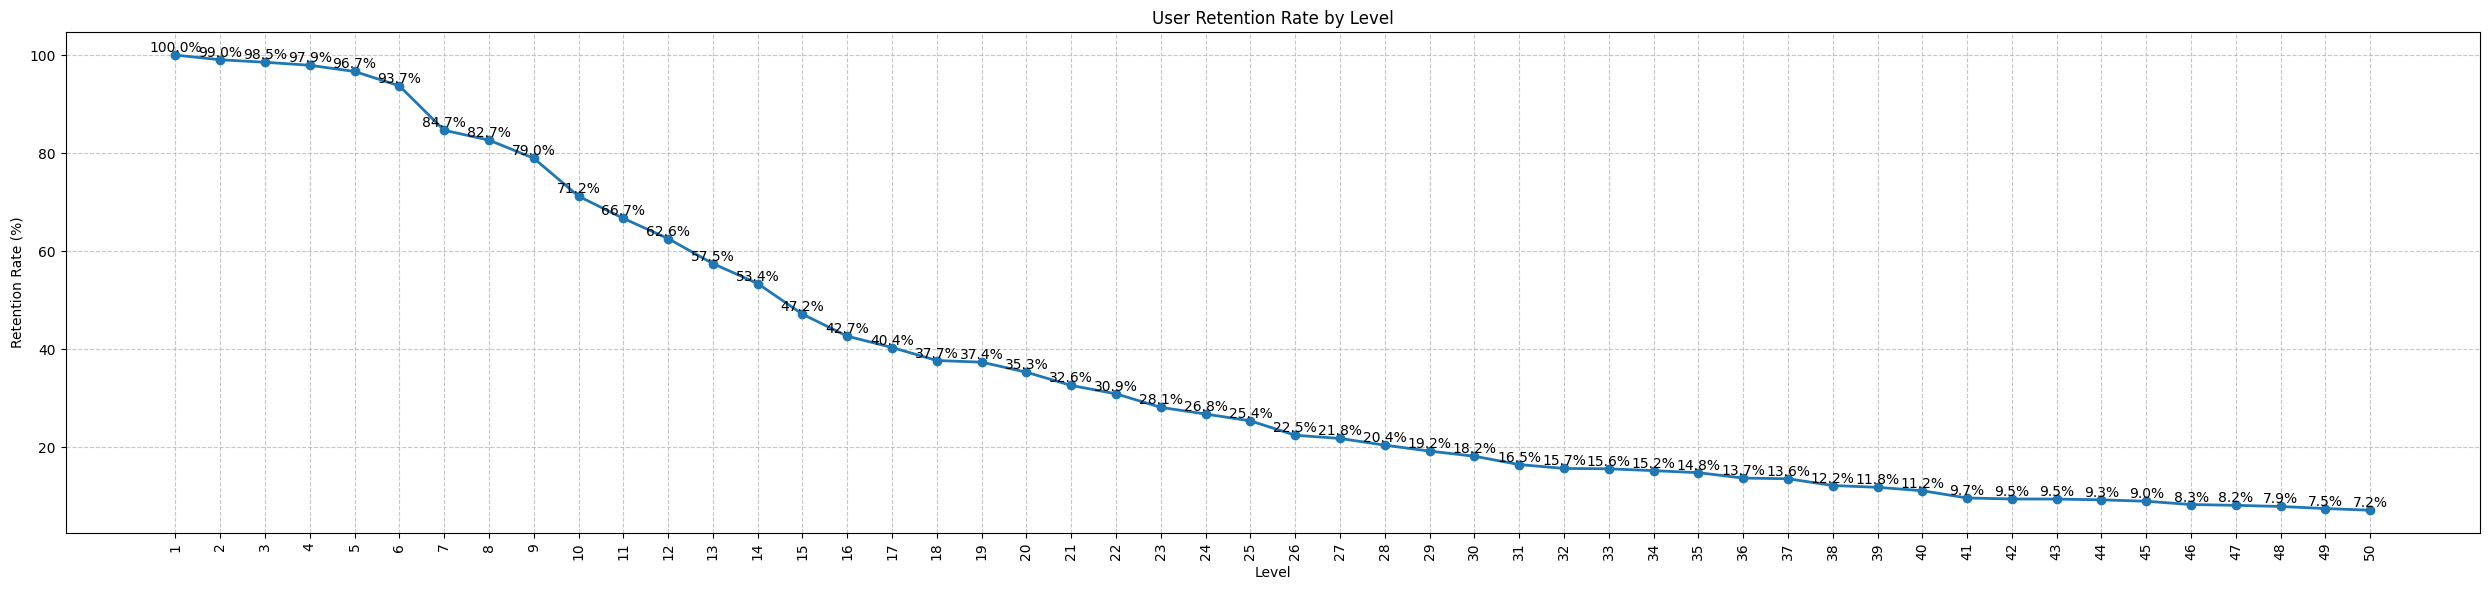

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Bỏ toàn bộ warning

import matplotlib.pyplot as plt

# Add start_level_1 column (number of users who started level 1)
df1['start_level_1'] = df1.loc[df1['level'] == 1, 'user_start'].iloc[0]

# Calculate retention rate as percentage of level 1 starters
df1['retention'] = (df1['user_start'] / df1['start_level_1']) * 100

# Create line chart for retention rate
plt.figure(figsize=(25, 6))
plt.plot(df1['level'], df1['retention'], marker='o', linewidth=2)

# Add data labels
for x, y in zip(df1['level'], df1['retention']):
    plt.text(x, y, f'{y:.1f}%', ha='center', va='bottom')

# Customize the plot
plt.xlabel('Level')
plt.ylabel('Retention Rate (%)')
plt.title('User Retention Rate by Level')
plt.grid(True, linestyle='--', alpha=0.7)

# Show all x-axis labels
plt.xticks(df1['level'], rotation=90)

plt.tight_layout()
plt.show()

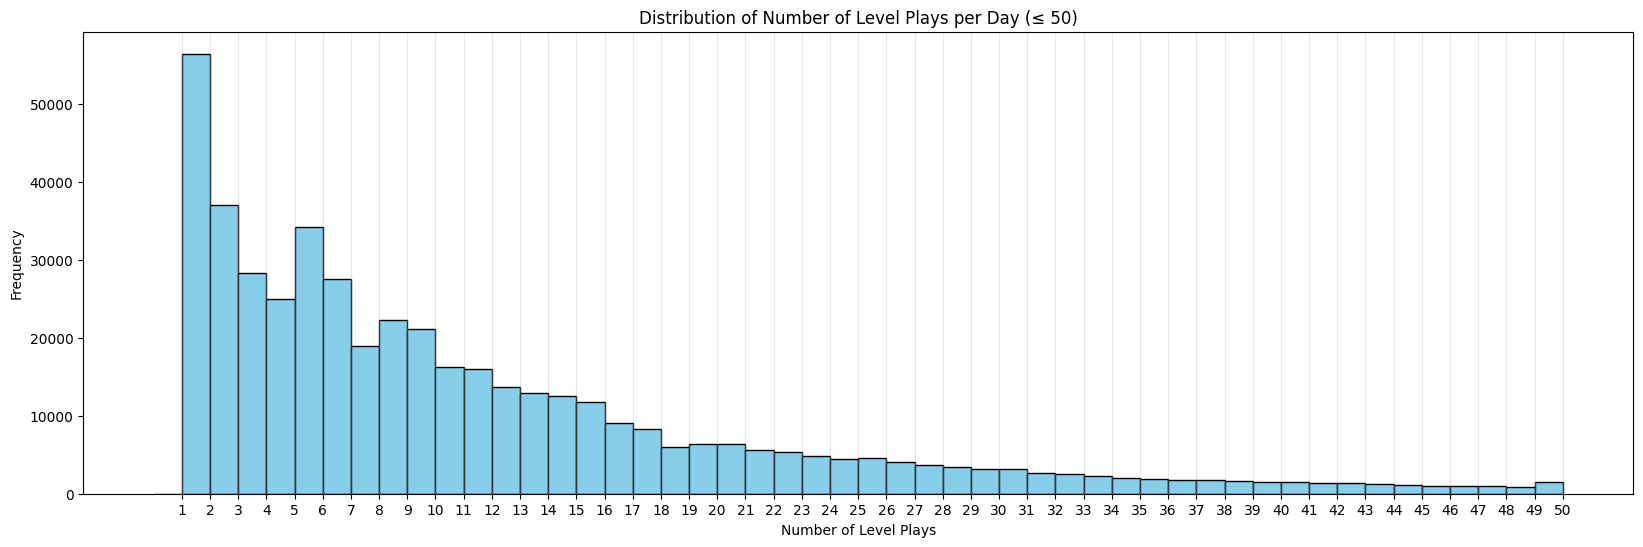

In [ ]:
query = """
select *
from `crazy-coffee-jam.dashboard_table.avg_level_play`
where event_date >= '2025-05-01'
"""
level_play_per_day = client.query(query).to_dataframe()
filtered_data = level_play_per_day[level_play_per_day['num_level_play'] <= 50]
plt.figure(figsize=(20, 6))
plt.hist(filtered_data['num_level_play'], bins=range(51), color='skyblue', edgecolor='black')
plt.xlabel('Number of Level Plays')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Level Plays per Day (≤ 50)')
plt.xticks(range(1, 51, 1))
plt.grid(True, axis='x', alpha=0.3)
plt.show()


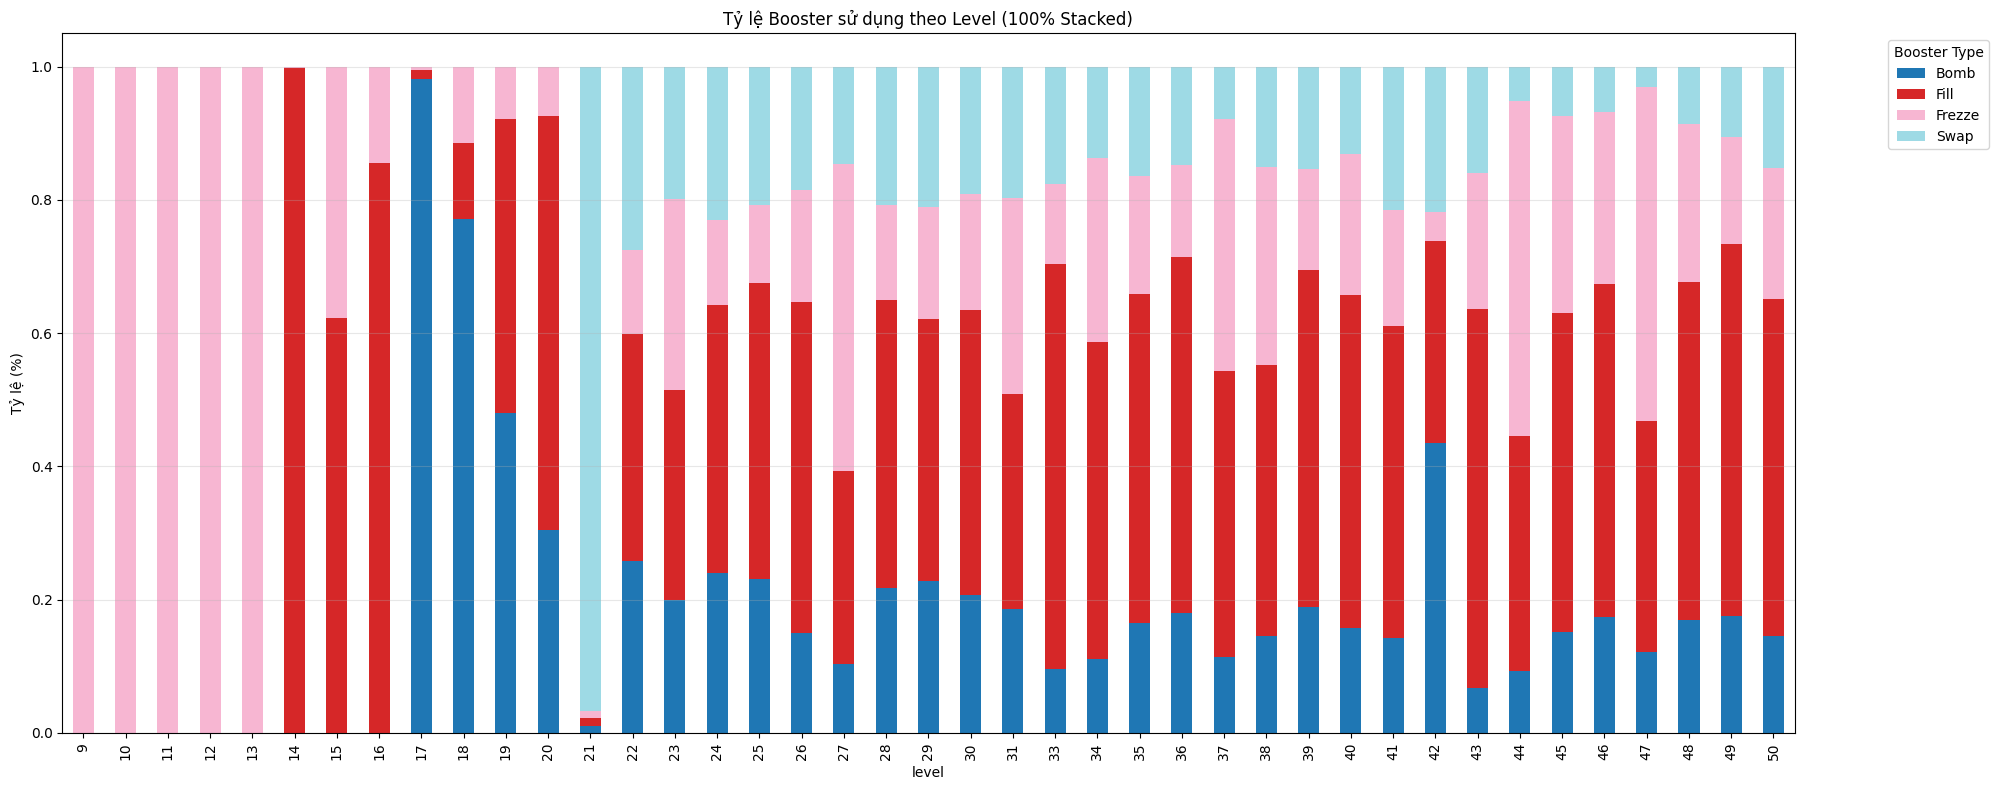

In [ ]:
query = f"""
select *
from `crazy-coffee-jam.flatten_table.booster_use`
where event_date between '{start_date}' and '{end_date}'
and version in ('{version}')
"""
level_booster1 = client.query(query).to_dataframe()
level_booster1 = level_booster1[level_booster1['level'] <= 50]
import pandas as pd
import matplotlib.pyplot as plt

# Bước 1: Tính số lượng booster sử dụng theo level và booster_type
booster_counts = level_booster1.groupby(['level', 'booster_type']).size().unstack(fill_value=0)

# Bước 2: Chuẩn hóa để ra tỷ lệ phần trăm (100% stacked)
booster_pct = booster_counts.div(booster_counts.sum(axis=1), axis=0)

# Bước 3: Vẽ stacked column chart
booster_pct.plot(kind='bar', stacked=True, figsize=(20, 8), colormap='tab20')

plt.ylabel('Tỷ lệ (%)')
plt.title('Tỷ lệ Booster sử dụng theo Level (100% Stacked)')
plt.legend(title='Booster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


#### Ver 1.0.18

In [ ]:
start_date = '2025-07-26'
end_date = '2025-08-08'
version = '1.1.21'

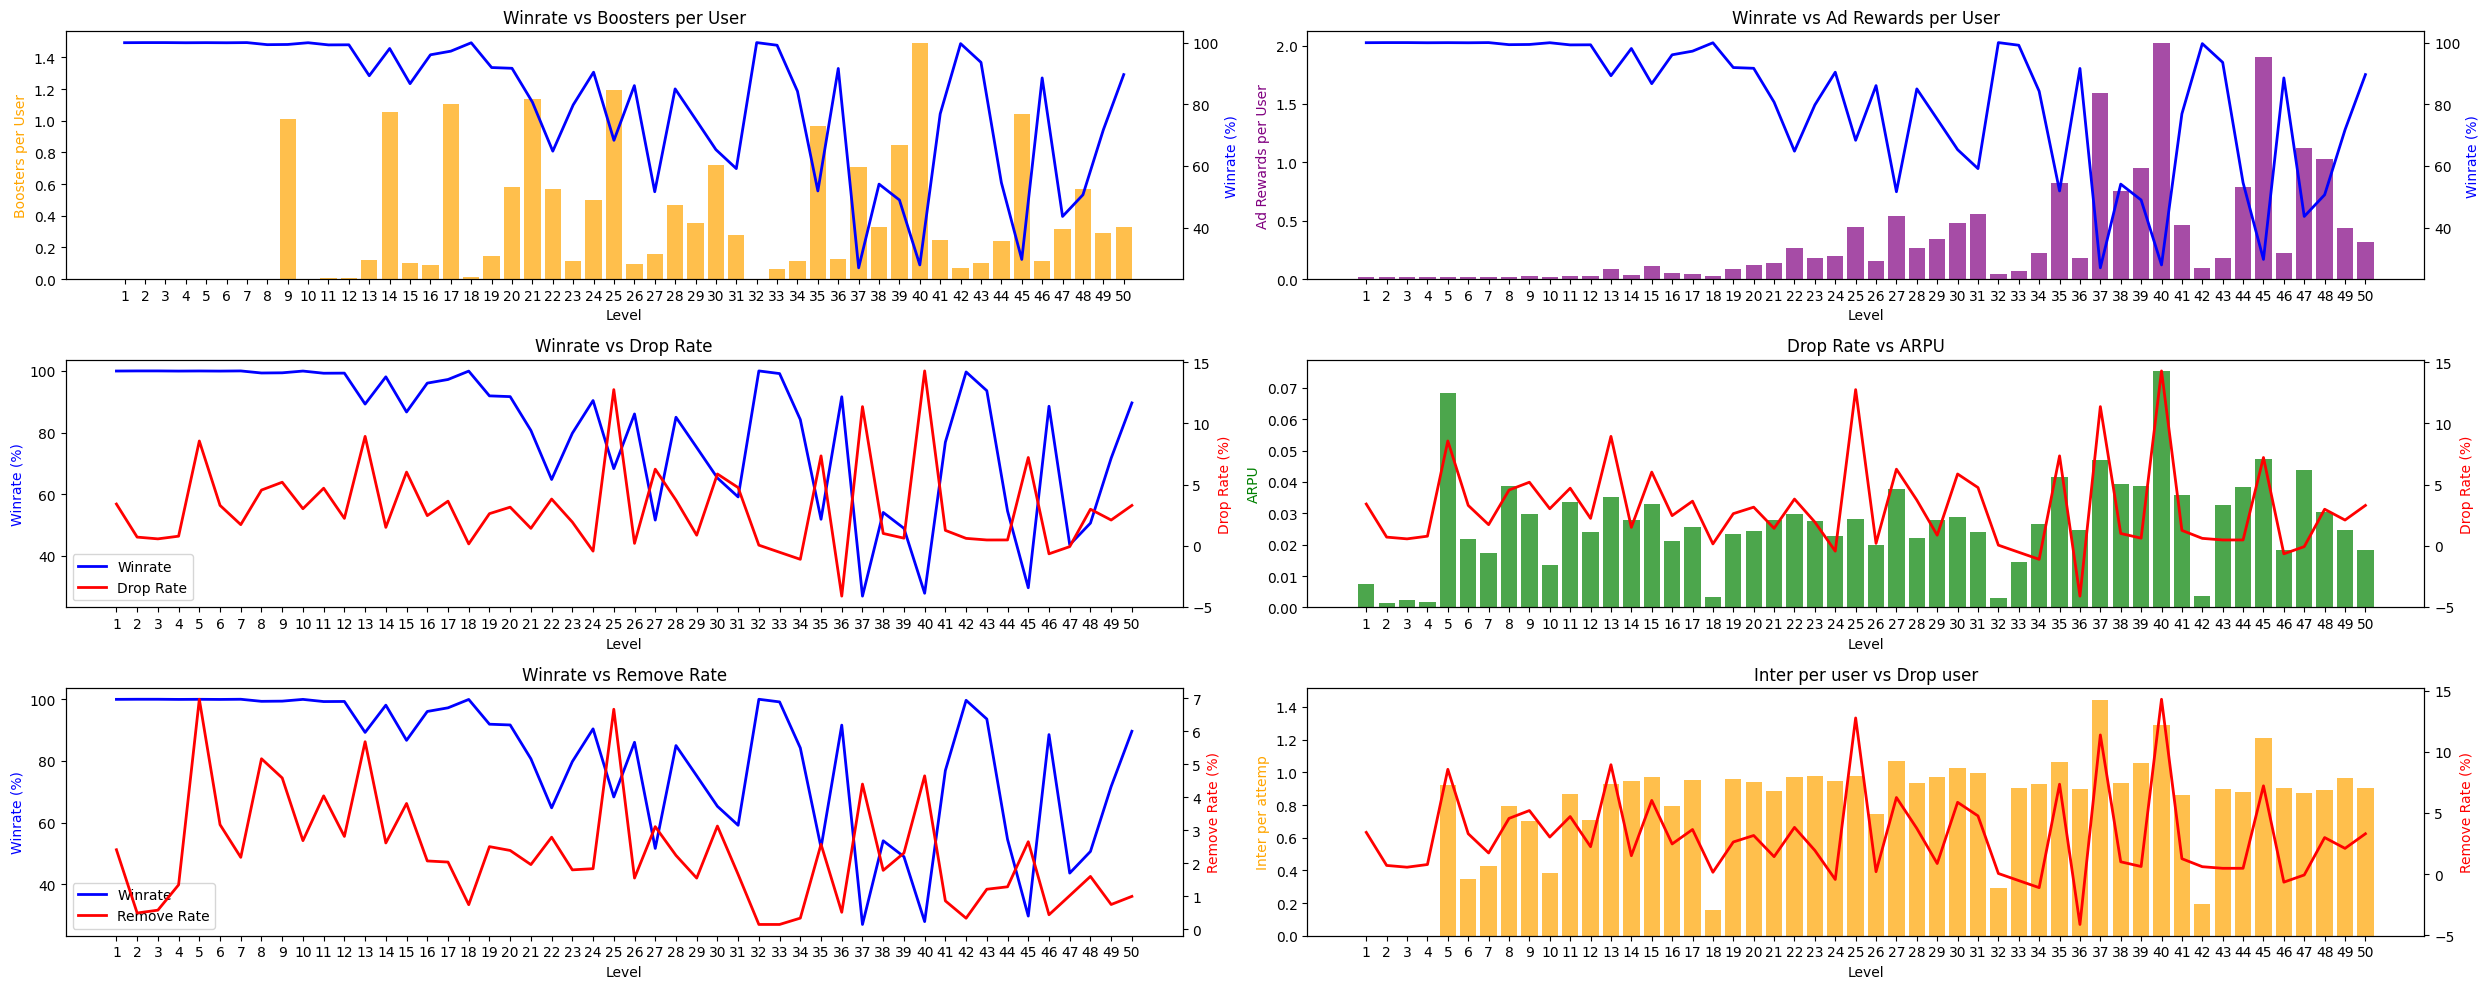

In [ ]:
# Winrate vs
query1 = f"""
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
),
  booster_use as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_booster_use
    FROM `crazy-coffee-jam.flatten_table.booster_use`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
    GROUP BY  level
  ),
  ad_reward as (
    SELECT
      level,
      COUNT(user_pseudo_id) as num_ad_reward
    FROM `crazy-coffee-jam.flatten_table.af_rewarded`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
    and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
    GROUP BY  level
  ),
ad_inter_attemp as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_inter_attemp
  FROM `crazy-coffee-jam.flatten_table.af_inter_attempt`
    where event_date between '{start_date}' and '{end_date}'
  and version = '{version}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-27')
  GROUP BY  level
)
SELECT
  safe_cast(s.level as int) as level,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose,
  COALESCE(r.event_revive, 0) as event_revive,
  COALESCE(b.num_booster_use, 0) as num_booster_use,
  COALESCE(a.num_ad_reward, 0) as num_ad_reward,
  COALESCE(ia.num_ad_inter_attemp, 0) as num_ad_inter_attemp,
  s.user_start,
  w.user_win,
  l.user_lose,
  r.user_revive
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN ad_inter_attemp ia
  ON s.level = ia.level;
"""
winrate = client.query(query1).to_dataframe()
# Điền các giá trị 0 vào các ô NA
winrate = winrate.fillna(0)
# sort
winrate = winrate.sort_values('level', ascending=True)
# ad_inter = 0 vào 1,2,3,4
winrate.loc[winrate['level'].isin([1, 2, 3, 4]), 'num_ad_inter_attemp'] = 0

# tạo df chứa app_remove và arpu by level
query = f"""
with a as (
select level, sum(total_revenue) as total_revenue
from `crazy-coffee-jam.dashboard_table.arpu_level`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
group by level
), b as (
select level, sum(num_user_remove) as num_user_remove
from `crazy-coffee-jam.dashboard_table.remove_by_level`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
group by level
)
select a.level, a.total_revenue, b.num_user_remove
from a left join b on a.level = b.level;
"""
arpu_remove = client.query(query).to_dataframe()
arpu_remove = arpu_remove.fillna(0)
arpu_remove = arpu_remove.sort_values('level', ascending=True)

# Nối 2 df qua level
df = winrate.merge(arpu_remove, on='level', how='left')

# Transform and add column
# Add next level's user_start count
df['user_start_next_level'] = df['user_start'].shift(-1)

# Calculate drop rate
df['drop_user'] = 1 - (df['user_start_next_level'] / df['user_start'])

# Calculate winrate
df['winrate'] = df['event_win'] / (df['event_win'] + df['event_lose'] + df['event_revive'])

# Convert winrate and drop_user to percentages
df['winrate'] = df['winrate'] * 100
df['drop_user'] = df['drop_user'] * 100

df['booster_per_user'] = df['num_booster_use'] / df['user_start']
df['ad_reward_per_user'] = df['num_ad_reward'] / df['user_start']

df['arpu'] = df['total_revenue'] / df['user_start']
df['remove_rate'] = df['num_user_remove'] / df['user_start'] * 100

df['ad_inter_attemp_per_user'] = df['num_ad_inter_attemp'] / df['user_start']

df2 = df[df['level'] <= 50]
# Create figure with 6 subplots (3 rows, 2 columns)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 10))
# Filter for levels <= 100
# 1st row, 1st column: winrate vs booster_per_user
ax1_twin = ax1.twinx()
ax1.bar(df2['level'], df2['booster_per_user'], color='orange', alpha=0.7)
ax1_twin.plot(df2['level'], df2['winrate'], color='blue', linewidth=2)
ax1.set_xlabel('Level')
ax1.set_ylabel('Boosters per User', color='orange')
ax1_twin.set_ylabel('Winrate (%)', color='blue')
ax1.set_title('Winrate vs Boosters per User')
ax1.set_xticks(df2['level'])

# 1st row, 2nd column: winrate vs ad_reward_per_user
ax2_twin = ax2.twinx()
ax2.bar(df2['level'], df2['ad_reward_per_user'], color='purple', alpha=0.7)
ax2_twin.plot(df2['level'], df2['winrate'], color='blue', linewidth=2)
ax2.set_xlabel('Level')
ax2.set_ylabel('Ad Rewards per User', color='purple')
ax2_twin.set_ylabel('Winrate (%)', color='blue')
ax2.set_title('Winrate vs Ad Rewards per User')
ax2.set_xticks(df2['level'])

# 2nd row, 1st column: winrate vs drop_user
ax3_twin = ax3.twinx()
ax3.plot(df2['level'], df2['winrate'], color='blue', linewidth=2, label='Winrate')
ax3_twin.plot(df2['level'], df2['drop_user'], color='red', linewidth=2, label='Drop Rate')
ax3.set_xlabel('Level')
ax3.set_ylabel('Winrate (%)', color='blue')
ax3_twin.set_ylabel('Drop Rate (%)', color='red')
ax3.set_title('Winrate vs Drop Rate')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2)
ax3.set_xticks(df2['level'])

# 2nd row, 2nd column: drop_user vs arpu
ax4_twin = ax4.twinx()
ax4.bar(df2['level'], df2['arpu'], color='green', alpha=0.7)
ax4_twin.plot(df2['level'], df2['drop_user'], color='red', linewidth=2)
ax4.set_xlabel('Level')
ax4.set_ylabel('ARPU', color='green')
ax4_twin.set_ylabel('Drop Rate (%)', color='red')
ax4.set_title('Drop Rate vs ARPU')
ax4.set_xticks(df2['level'])

# 3rd row, 1st column: winrate vs remove_rate
ax5_twin = ax5.twinx()
ax5.plot(df2['level'], df2['winrate'], color='blue', linewidth=2, label='Winrate')
ax5_twin.plot(df2['level'], df2['remove_rate'], color='red', linewidth=2, label='Remove Rate')
ax5.set_xlabel('Level')
ax5.set_ylabel('Winrate (%)', color='blue')
ax5_twin.set_ylabel('Remove Rate (%)', color='red')
ax5.set_title('Winrate vs Remove Rate')
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2)
ax5.set_xticks(df2['level'])

# 3rd row, 2nd column: remove_rate vs arpu
ax6_twin = ax6.twinx()
ax6.bar(df2['level'], df2['ad_inter_attemp_per_user'], color='orange', alpha=0.7)
ax6_twin.plot(df2['level'], df2['drop_user'], color='red', linewidth=2)
ax6.set_xlabel('Level')
ax6.set_ylabel('Inter per attemp', color='orange')
ax6_twin.set_ylabel('Remove Rate (%)', color='red')
ax6.set_title('Inter per user vs Drop user')
ax6.set_xticks(df2['level'])

# Adjust layout and display
plt.tight_layout()
plt.show()

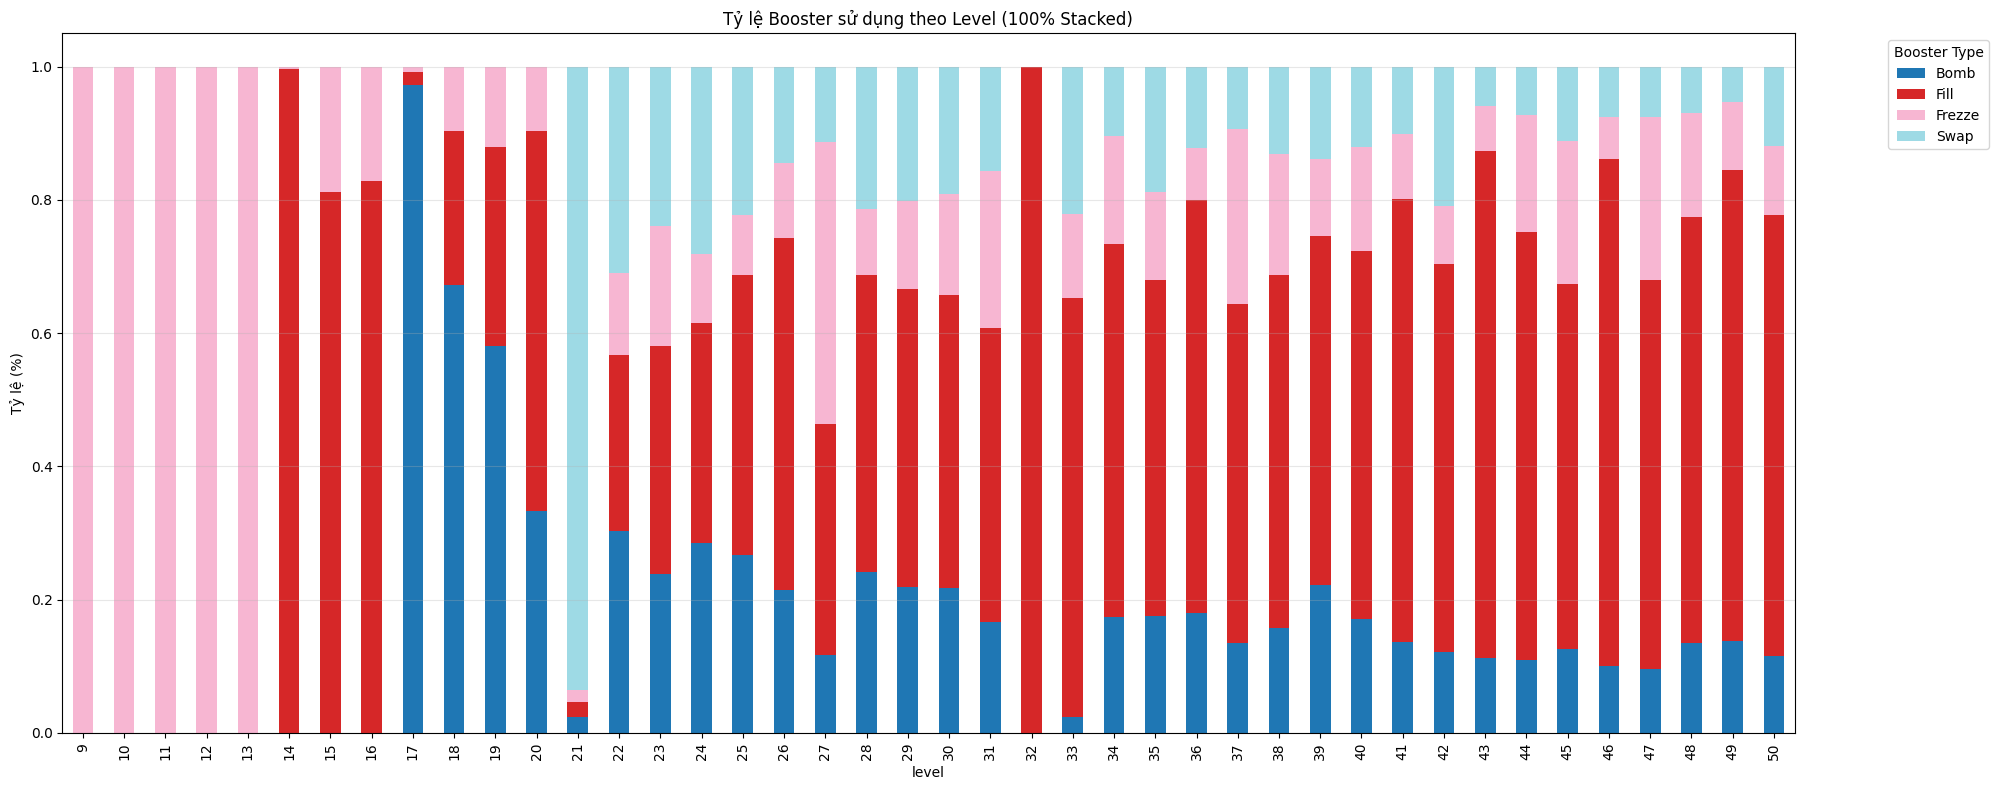

In [ ]:
query = f"""
select *
from `crazy-coffee-jam.flatten_table.booster_use`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
"""
level_booster1 = client.query(query).to_dataframe()
level_booster1 = level_booster1[level_booster1['level'] <= 50]
import pandas as pd
import matplotlib.pyplot as plt

# Bước 1: Tính số lượng booster sử dụng theo level và booster_type
booster_counts = level_booster1.groupby(['level', 'booster_type']).size().unstack(fill_value=0)

# Bước 2: Chuẩn hóa để ra tỷ lệ phần trăm (100% stacked)
booster_pct = booster_counts.div(booster_counts.sum(axis=1), axis=0)

# Bước 3: Vẽ stacked column chart
booster_pct.plot(kind='bar', stacked=True, figsize=(20, 8), colormap='tab20')

plt.ylabel('Tỷ lệ (%)')
plt.title('Tỷ lệ Booster sử dụng theo Level (100% Stacked)')
plt.legend(title='Booster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


#### Compare 2 version

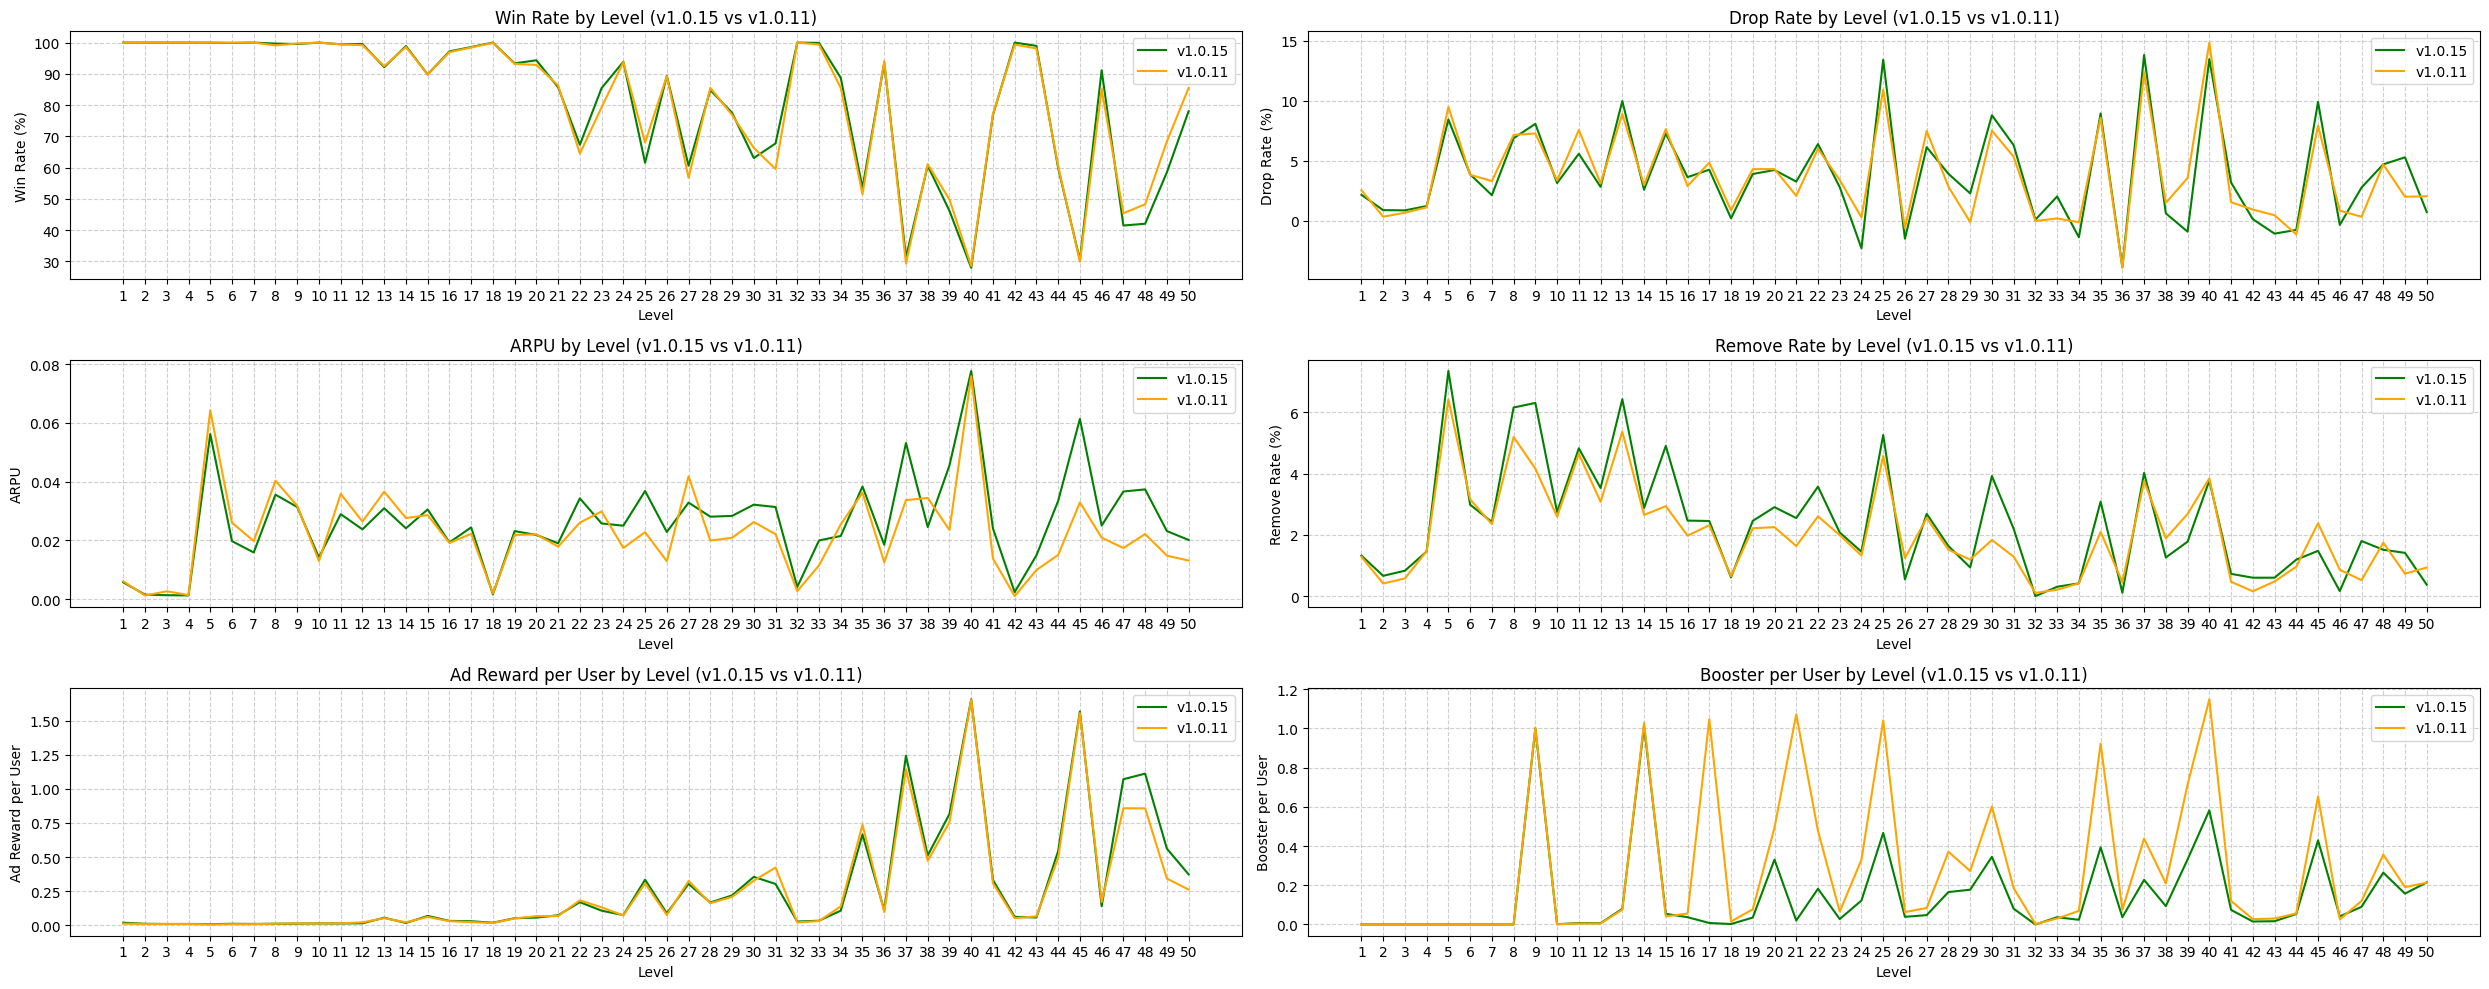

In [ ]:
# prompt: df1: is for version 1.0.15, df2: is for version 1.0.11. Now i want to create 6 subplot: (green for ver 1.0.15, orange for ver 1.0.11)
# - (0,0): win_rate between 2 version (line) by level
# - (0,1): drop_rate between 2 version (line) by level
# - (1,0): arpu between 2 version (line) by level
# - (1,1): remove_rate between 2 version (line) by level
# - (2,0): ad_reward_per_user between 2 version (line) by level
# - (2,1): booster_per_user between 2 version (line) by level

# Create figure with 3 rows and 2 columns for the subplots
fig, axes = plt.subplots(3, 2, figsize=(25, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create x-ticks for levels 1-50
levels = list(range(1, 51))

# (0,0): win_rate between 2 version (line) by level
axes[0].plot(df1['level'], df1['winrate'], color='green', label='v1.0.15')
axes[0].plot(df2['level'], df2['winrate'], color='orange', label='v1.0.11')
axes[0].set_xlabel('Level')
axes[0].set_ylabel('Win Rate (%)')
axes[0].set_title('Win Rate by Level (v1.0.15 vs v1.0.11)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(levels)

# (0,1): drop_rate between 2 version (line) by level
axes[1].plot(df1['level'], df1['drop_user'], color='green', label='v1.0.15')
axes[1].plot(df2['level'], df2['drop_user'], color='orange', label='v1.0.11')
axes[1].set_xlabel('Level')
axes[1].set_ylabel('Drop Rate (%)')
axes[1].set_title('Drop Rate by Level (v1.0.15 vs v1.0.11)')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(levels)

# (1,0): arpu between 2 version (line) by level
axes[2].plot(df1['level'], df1['arpu'], color='green', label='v1.0.15')
axes[2].plot(df2['level'], df2['arpu'], color='orange', label='v1.0.11')
axes[2].set_xlabel('Level')
axes[2].set_ylabel('ARPU')
axes[2].set_title('ARPU by Level (v1.0.15 vs v1.0.11)')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].set_xticks(levels)

# (1,1): remove_rate between 2 version (line) by level
axes[3].plot(df1['level'], df1['remove_rate'], color='green', label='v1.0.15')
axes[3].plot(df2['level'], df2['remove_rate'], color='orange', label='v1.0.11')
axes[3].set_xlabel('Level')
axes[3].set_ylabel('Remove Rate (%)')
axes[3].set_title('Remove Rate by Level (v1.0.15 vs v1.0.11)')
axes[3].legend()
axes[3].grid(True, linestyle='--', alpha=0.6)
axes[3].set_xticks(levels)

# (2,0): ad_reward_per_user between 2 version (line) by level
axes[4].plot(df1['level'], df1['ad_reward_per_user'], color='green', label='v1.0.15')
axes[4].plot(df2['level'], df2['ad_reward_per_user'], color='orange', label='v1.0.11')
axes[4].set_xlabel('Level')
axes[4].set_ylabel('Ad Reward per User')
axes[4].set_title('Ad Reward per User by Level (v1.0.15 vs v1.0.11)')
axes[4].legend()
axes[4].grid(True, linestyle='--', alpha=0.6)
axes[4].set_xticks(levels)

# (2,1): booster_per_user between 2 version (line) by level
axes[5].plot(df1['level'], df1['booster_per_user'], color='green', label='v1.0.15')
axes[5].plot(df2['level'], df2['booster_per_user'], color='orange', label='v1.0.11')
axes[5].set_xlabel('Level')
axes[5].set_ylabel('Booster per User')
axes[5].set_title('Booster per User by Level (v1.0.15 vs v1.0.11)')
axes[5].legend()
axes[5].grid(True, linestyle='--', alpha=0.6)
axes[5].set_xticks(levels)

# Adjust layout
plt.tight_layout()
plt.show()

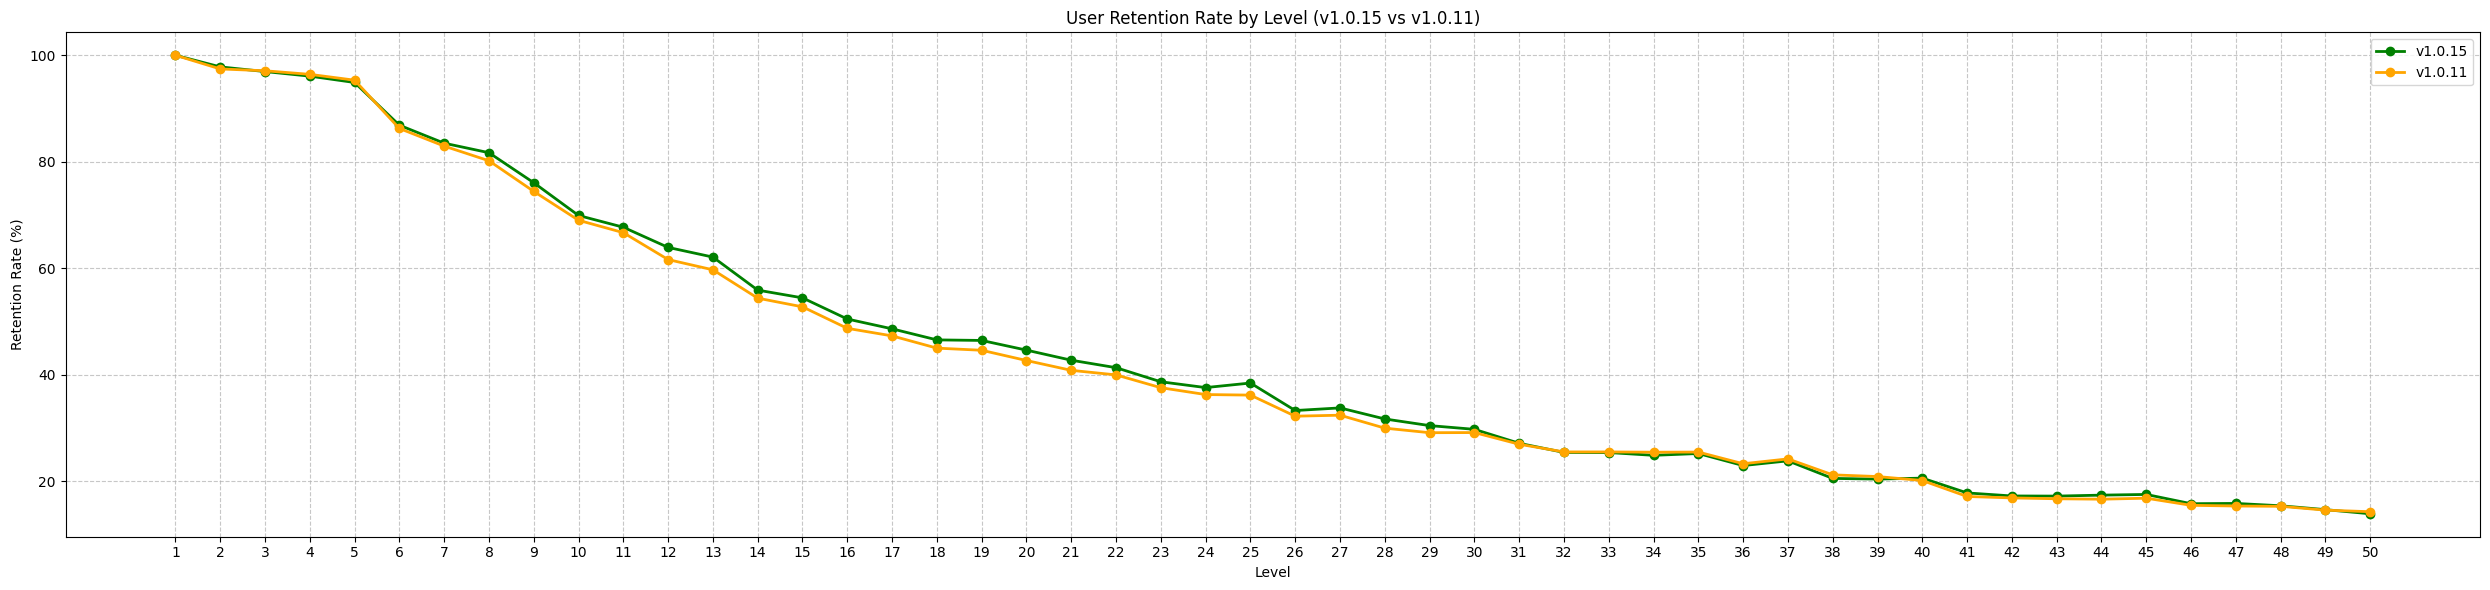

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Bỏ toàn bộ warning

import matplotlib.pyplot as plt

# Calculate retention rate for df2 (version 1.0.11)
df2['start_level_1'] = df2.loc[df2['level'] == 1, 'user_start'].iloc[0]
df2['retention'] = (df2['user_start'] / df2['start_level_1']) * 100

# Create comparative line chart
plt.figure(figsize=(25, 6))

# Plot retention for df1 (v1.0.15)
plt.plot(df1['level'], df1['retention'], marker='o', linewidth=2, color='green', label='v1.0.15')

# Plot retention for df2 (v1.0.11)
plt.plot(df2['level'], df2['retention'], marker='o', linewidth=2, color='orange', label='v1.0.11')

# # Add data labels for df1
# for x, y in zip(df1['level'], df1['retention']):
#     plt.text(x, y, f'{y:.1f}%', ha='center', va='bottom', color='green')

# # Add data labels for df2
# for x, y in zip(df2['level'], df2['retention']):
#     plt.text(x, y, f'{y:.1f}%', ha='center', va='bottom', color='orange')

# Customize the plot
plt.xlabel('Level')
plt.ylabel('Retention Rate (%)')
plt.title('User Retention Rate by Level (v1.0.15 vs v1.0.11)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show all x-axis labels
plt.xticks(df1['level']) # Assuming df1 and df2 have the same levels up to 50

plt.tight_layout()
plt.show()

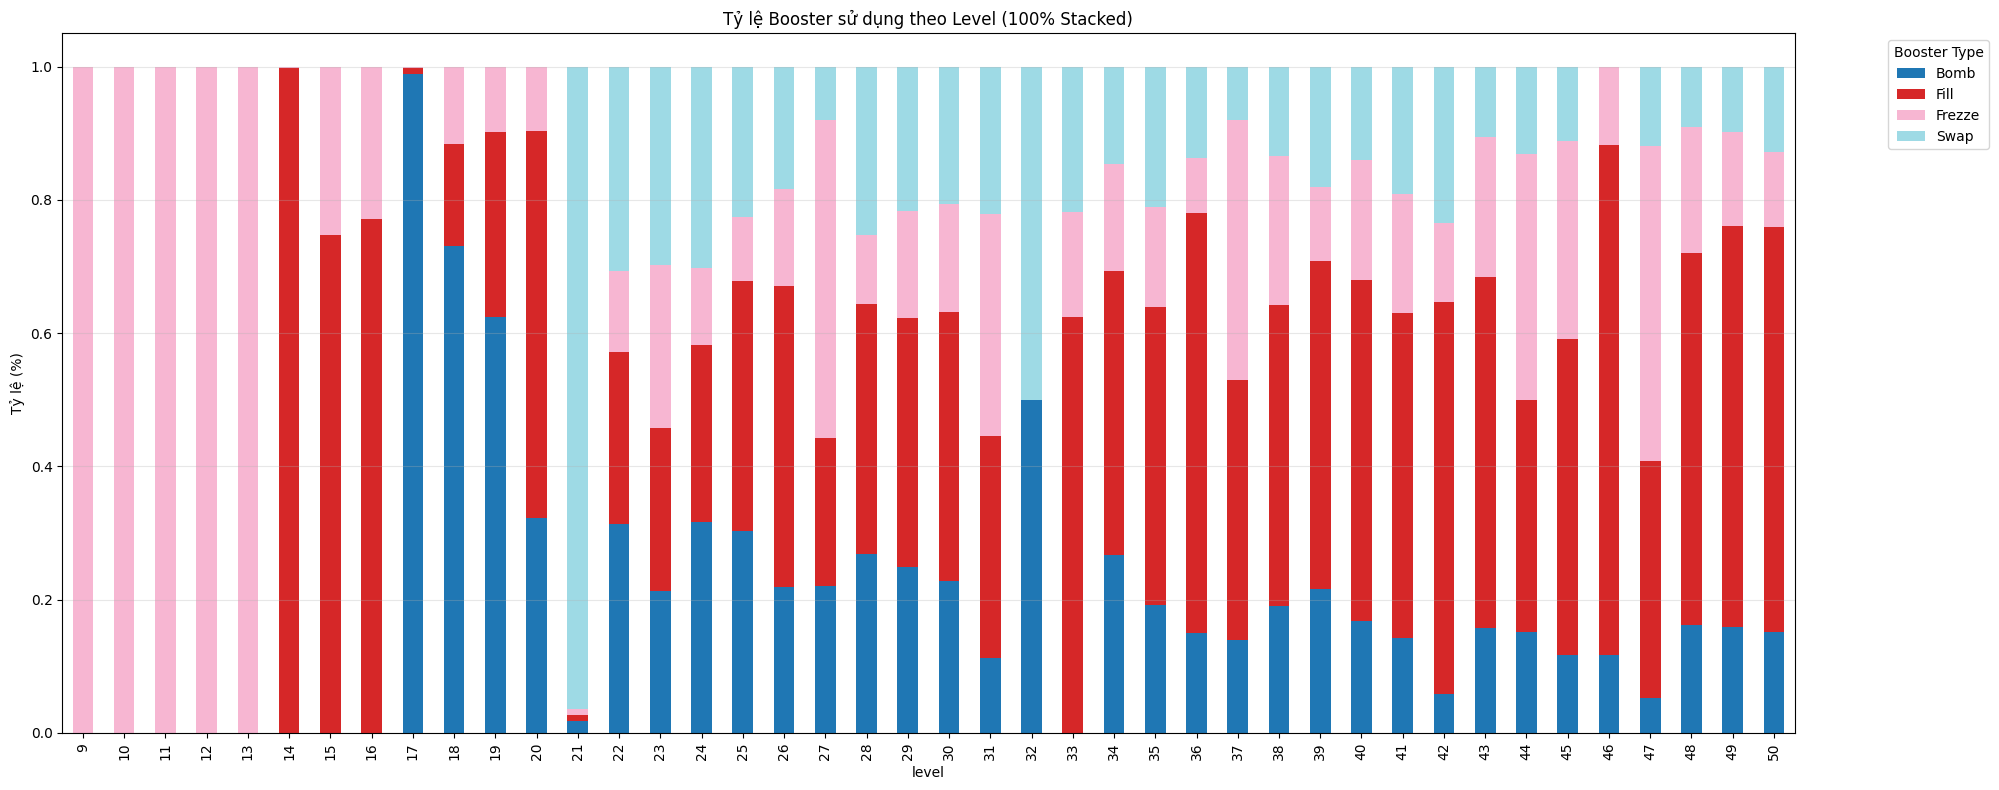

In [ ]:
query = f"""
select *
from `crazy-coffee-jam.flatten_table.booster_use`
where event_date between '{start_date}' and '{end_date}'
and version = '{version}'
"""
level_booster = client.query(query).to_dataframe()
level_booster = level_booster[level_booster['level'] <= 50]
import pandas as pd
import matplotlib.pyplot as plt

# Bước 1: Tính số lượng booster sử dụng theo level và booster_type
booster_counts = level_booster.groupby(['level', 'booster_type']).size().unstack(fill_value=0)

# Bước 2: Chuẩn hóa để ra tỷ lệ phần trăm (100% stacked)
booster_pct = booster_counts.div(booster_counts.sum(axis=1), axis=0)

# Bước 3: Vẽ stacked column chart
booster_pct.plot(kind='bar', stacked=True, figsize=(20, 8), colormap='tab20')

plt.ylabel('Tỷ lệ (%)')
plt.title('Tỷ lệ Booster sử dụng theo Level (100% Stacked)')
plt.legend(title='Booster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


# Sequence of user drop level 8

In [ ]:
query = """
with a as (
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where level >= 9
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
)
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where event_date >= '2025-05-01'
and level = 8
and user_pseudo_id not in (select user_pseudo_id from a)
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
"""
user_drop_level_8 = client.query(query).to_dataframe()
user_drop_level_8_list = user_drop_level_8['user_pseudo_id'].tolist()

NameError: name 'client' is not defined

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250501' AND '20250525'
  and user_pseudo_id in ('{("','".join(user_drop_level_8_list))}')
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression')
  and key not in ('firebase_event_origin','firebase_screen_class','ga_session_number', 'engaged_session_event', 'firebase_screen_id', 'ga_session_id', 'firebase_event_id',
  'engagement_time_msec', 'system_app', 'previous_first_open_count', 'system_app_update', 'firebase_conversion', 'update_with_analytics', 'level_percent','IsLoop',
  'value', 'ad_platform', 'ad_unit_name', 'currency','ad_source')
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()

In [ ]:
# Chỉ lấy các event sau khi user bắt đầu level 8
# Get the timestamp when each user started level 8
level_8_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '8')
].groupby('user_pseudo_id')['event_timestamp'].min()

# Filter sequence_user to only include events after each user's level 8 start
sequence_user = sequence_user.merge(
    level_8_start_times.reset_index(),
    on='user_pseudo_id',
    suffixes=('', '_level8_start')
)
sequence_user = sequence_user[
    sequence_user['event_timestamp'] >= sequence_user['event_timestamp_level8_start']
].drop('event_timestamp_level8_start', axis=1)

# Bỏ các dòng có event_name là booster_use và key là level và value là 8
sequence_user = sequence_user[
    ~((sequence_user['event_name'] == 'booster_use') &
      (sequence_user['key'] == 'level') &
      (sequence_user['value'] == '8'))
]

# Drop rows where value is 'BANNER'
sequence_user = sequence_user[sequence_user['value'] != 'BANNER']
sequence_user = sequence_user[sequence_user['value'] != 'LEADER']

# For ad_impression events, replace event_name with the corresponding value
sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'event_name'] = sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'value']

sequence_user

user_pseudo_id   event_name   event_timestamp  \
41     0005abff796753973e9ef6241e02d636  start_level  1746524668723519   
43     0005abff796753973e9ef6241e02d636  booster_use  1746524674356521   
46     0005abff796753973e9ef6241e02d636     REWARDED  1746524879281519   
75     000b1cf405ea9ac1ae37ac761815cba7  start_level  1746838936306709   
76     000b1cf405ea9ac1ae37ac761815cba7  booster_use  1746838940381711   
...                                 ...          ...               ...   
85486  ffd9c30e04c487cee4701bb35a060749  booster_use  1747867469958517   
85522  fff7b258d6cddb69af658de0b448b768  start_level  1747202322656607   
85524  fff7b258d6cddb69af658de0b448b768  booster_use  1747202329625609   
85535  fff7b258d6cddb69af658de0b448b768    win_level  1747202533570262   
85536  fff7b258d6cddb69af658de0b448b768        INTER  1747202542502252   

                key     value  
41            level         8  
43     booster_type    Frezze  
46        ad_format  REWARDED  
75            level         8  
76     booster_type    Frezze  
...             ...       ...  
85486  booster_type    Frezze  
85522         level         8  
85524  booster_type    Frezze  
85535         level         8  
85536     ad_format     INTER  

[7856 rows x 5 columns]

In [ ]:
# Bước 4: Lấy thời điểm start_level 9 của từng user (nếu có)
level_9_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '9')
].groupby('user_pseudo_id')['event_timestamp'].min().reset_index().rename(columns={'event_timestamp': 'start_level_9_time'})

# Merge và lọc các hành vi *trước* thời điểm start_level 9 nếu có
sequence_user = sequence_user.merge(level_9_start_times, on='user_pseudo_id', how='left')
sequence_user = sequence_user[
    (sequence_user['start_level_9_time'].isna()) |  # giữ user không có level 9
    (sequence_user['event_timestamp'] <= sequence_user['start_level_9_time'])
]
sequence_user = sequence_user.drop(columns=['start_level_9_time'])

# prompt: sequence_user: Bỏ đi các dòng có key = level và value ứng với level đó >= 9

sequence_user = sequence_user[
    ~((sequence_user['key'] == 'level') &
      (pd.to_numeric(sequence_user['value'], errors='coerce') >= 9))
]


In [ ]:
# Group events by user_pseudo_id and aggregate event_names into a sequence
sequence_df = sequence_user.groupby('user_pseudo_id').agg(
    sequence=('event_name', lambda x: ' -> '.join(x))
).reset_index()

sequence_df

user_pseudo_id  \
0     0005abff796753973e9ef6241e02d636   
1     000b1cf405ea9ac1ae37ac761815cba7   
2     002d60067763bd3fb22ffd24ad1dd424   
3     002f795faeb69377468c27da3364e743   
4     008c00273819a7ccbcac538c1b687041   
...                                ...   
2223  ff8ea320a832ac7f4f52e98a2660bd7a   
2224  ff934ad018e44b6ce2bfd79e7c109724   
2225  ff9785c48aa0a3cb80f06202a5acdd0d   
2226  ffd9c30e04c487cee4701bb35a060749   
2227  fff7b258d6cddb69af658de0b448b768   

                                              sequence  
0               start_level -> booster_use -> REWARDED  
1            start_level -> booster_use -> start_level  
2     start_level -> booster_use -> win_level -> INTER  
3                           start_level -> booster_use  
4                           start_level -> booster_use  
...                                                ...  
2223  start_level -> booster_use -> win_level -> INTER  
2224  start_level -> booster_use -> win_level -> INTER  
2225  start_level -> booster_use -> win_level -> INTER  
2226         start_level -> booster_use -> booster_use  
2227  start_level -> booster_use -> win_level -> INTER  

[2228 rows x 2 columns]

In [ ]:
sequence_df['sequence'] = sequence_df['sequence'] + ' -> drop'

In [ ]:
# Convert sequences to nodes and links for Sankey diagram
sequences = sequence_df['sequence'].str.split(' -> ')

# Get all unique events
all_events = set()
for seq in sequences:
    all_events.update(seq)

# Create nodes list
nodes = list(all_events)

# Create links dictionary to count transitions
links = {}
for seq in sequences:
    for i in range(len(seq)-1):
        source = seq[i]
        target = seq[i+1]
        key = (source, target)
        links[key] = links.get(key, 0) + 1

# Create source, target and value lists for plotting
source_list = []
target_list = []
value_list = []
for (source, target), value in links.items():
    source_list.append(nodes.index(source))
    target_list.append(nodes.index(target))
    value_list.append(value)

# Create Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = nodes,
        color = "blue"
    ),
    link = dict(
        source = source_list,
        target = target_list,
        value = value_list
    )
)])

fig.update_layout(title_text="User Flow Sankey Diagram", font_size=10)
fig.show()

Kết luận: Lý do mà user drop nhiều nhất tại level 8 là do:
- Booster ko hay, user vừa bấm vào dùng thấy nó như cc nên drop luôn
- Bị ảnh hưởng bởi inter, có rất nhiều user win level -> bị bắn inter nên drop

# Sequence of user drop level 15

In [ ]:
query = """
with a as (
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where level >= 16
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
)
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where event_date >= '2025-05-01'
and level = 15
and user_pseudo_id not in (select user_pseudo_id from a)
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
"""
user_drop_level_15 = client.query(query).to_dataframe()
user_drop_level_15_list = user_drop_level_15['user_pseudo_id'].tolist()

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250422' AND '20250519'
  and user_pseudo_id in ('{("','".join(user_drop_level_15_list))}')
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression')
  and key not in ('firebase_event_origin','firebase_screen_class','ga_session_number', 'engaged_session_event', 'firebase_screen_id', 'ga_session_id', 'firebase_event_id',
  'engagement_time_msec', 'system_app', 'previous_first_open_count', 'system_app_update', 'firebase_conversion', 'update_with_analytics', 'level_percent','IsLoop',
  'value', 'ad_platform', 'ad_unit_name', 'currency','ad_source')
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()

In [ ]:
# Chỉ lấy các event sau khi user bắt đầu level 15
# Get the timestamp when each user started level 15
level_15_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '15')
].groupby('user_pseudo_id')['event_timestamp'].min()

# Filter sequence_user to only include events after each user's level 15 start
sequence_user = sequence_user.merge(
    level_15_start_times.reset_index(),
    on='user_pseudo_id',
    suffixes=('', '_level15_start')
)
sequence_user = sequence_user[
    sequence_user['event_timestamp'] >= sequence_user['event_timestamp_level15_start']
].drop('event_timestamp_level15_start', axis=1)

# Bỏ các dòng có event_name là booster_use và key là level và value là 15
sequence_user = sequence_user[
    ~((sequence_user['event_name'] == 'booster_use') &
      (sequence_user['key'] == 'level') &
      (sequence_user['value'] == '15'))
]

# Drop rows where value is 'BANNER'
sequence_user = sequence_user[sequence_user['value'] != 'BANNER']
sequence_user = sequence_user[sequence_user['value'] != 'LEADER']

# For ad_impression events, replace event_name with the corresponding value
sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'event_name'] = sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'value']

sequence_user

user_pseudo_id   event_name   event_timestamp  \
32      001ab56758356022472c8733566cbaec  start_level  1747576899721078   
33      001ab56758356022472c8733566cbaec   lose_level  1747577136735061   
34      001ab56758356022472c8733566cbaec  start_level  1747577138508064   
40      001ab56758356022472c8733566cbaec   lose_level  1747580992847870   
41      001ab56758356022472c8733566cbaec        INTER  1747580995288863   
...                                  ...          ...               ...   
131623  fffeda73def58ca84be21651950e6f9f  start_level  1747271455406727   
131624  fffeda73def58ca84be21651950e6f9f  start_level  1747271736274064   
131636  fffeda73def58ca84be21651950e6f9f  start_level  1747348037338954   
131640  fffeda73def58ca84be21651950e6f9f  booster_use  1747348075001106   
131642  fffeda73def58ca84be21651950e6f9f  booster_use  1747348075001106   

                 key   value  
32             level      15  
33             level      15  
34             level      15  
40             level      15  
41         ad_format   INTER  
...              ...     ...  
131623         level      15  
131624         level      15  
131636         level      15  
131640  booster_type  Frezze  
131642  booster_type  Frezze  

[5908 rows x 5 columns]

In [ ]:
# Bước 4: Lấy thời điểm start_level 16 của từng user (nếu có)
level_16_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '16')
].groupby('user_pseudo_id')['event_timestamp'].min().reset_index().rename(columns={'event_timestamp': 'start_level_16_time'})

# Merge và lọc các hành vi *trước* thời điểm start_level 16 nếu có
sequence_user = sequence_user.merge(level_16_start_times, on='user_pseudo_id', how='left')
sequence_user = sequence_user[
    (sequence_user['start_level_16_time'].isna()) |  # giữ user không có level 16
    (sequence_user['event_timestamp'] <= sequence_user['start_level_16_time'])
]
sequence_user = sequence_user.drop(columns=['start_level_16_time'])

# prompt: sequence_user: Bỏ đi các dòng có key = level và value ứng với level đó >= 16

sequence_user = sequence_user[
    ~((sequence_user['key'] == 'level') &
      (pd.to_numeric(sequence_user['value'], errors='coerce') >= 16))
]


In [ ]:
# Group events by user_pseudo_id and aggregate event_names into a sequence
sequence_df = sequence_user.groupby('user_pseudo_id').agg(
    sequence=('event_name', lambda x: ' -> '.join(x))
).reset_index()

sequence_df

user_pseudo_id  \
0     001ab56758356022472c8733566cbaec   
1     001daff6aff341f8c689b4031fafae51   
2     001fe2fb86263dcd8980cfbe84bdd308   
3     0028ffde246d3660ccb6e48ece54d639   
4     003547177934245a5cae775495e538ba   
...                                ...   
1150  ffa125f4882c2ba9d9ac531dee4399c4   
1151  ffa89ce0643ce653e45bc2fcb3491fd4   
1152  ffa9cf7bb08c4ddaa2814cae437bbee9   
1153  ffbd3ad282ec49d5081370f18d346e95   
1154  fffeda73def58ca84be21651950e6f9f   

                                               sequence  
0     start_level -> lose_level -> start_level -> lo...  
1                    start_level -> lose_level -> INTER  
2     start_level -> lose_level -> INTER -> start_level  
3                                           start_level  
4     start_level -> lose_level -> INTER -> start_le...  
...                                                 ...  
1150  start_level -> REWARDED -> start_level -> lose...  
1151                start_level -> REWARDED -> REWARDED  
1152                          start_level -> lose_level  
1153                                        start_level  
1154  start_level -> REWARDED -> start_level -> star...  

[1155 rows x 2 columns]

In [ ]:
sequence_df['sequence'] = sequence_df['sequence'] + ' -> drop'

In [ ]:
# Convert sequences to nodes and links for Sankey diagram
sequences = sequence_df['sequence'].str.split(' -> ')

# Get all unique events
all_events = set()
for seq in sequences:
    all_events.update(seq)

# Create nodes list
nodes = list(all_events)

# Create links dictionary to count transitions
links = {}
for seq in sequences:
    for i in range(len(seq)-1):
        source = seq[i]
        target = seq[i+1]
        key = (source, target)
        links[key] = links.get(key, 0) + 1

# Create source, target and value lists for plotting
source_list = []
target_list = []
value_list = []
for (source, target), value in links.items():
    source_list.append(nodes.index(source))
    target_list.append(nodes.index(target))
    value_list.append(value)

# Create Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = nodes,
        color = "blue"
    ),
    link = dict(
        source = source_list,
        target = target_list,
        value = value_list
    )
)])

fig.update_layout(title_text="User Flow Sankey Diagram", font_size=10)
fig.show()

Level 15 drop vì logic khó

# Sequence of user drop level 5

In [ ]:
query = """
with a as (
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where level >= 6
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
)
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where event_date >= '2025-05-01'
and level = 5
and user_pseudo_id not in (select user_pseudo_id from a)
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
"""
user_drop_level_5 = client.query(query).to_dataframe()
user_drop_level_5_list = user_drop_level_5['user_pseudo_id'].tolist()

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250422' AND '20250519'
  and user_pseudo_id in ('{("','".join(user_drop_level_5_list))}')
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression')
  and key not in ('firebase_event_origin','firebase_screen_class','ga_session_number', 'engaged_session_event', 'firebase_screen_id', 'ga_session_id', 'firebase_event_id',
  'engagement_time_msec', 'system_app', 'previous_first_open_count', 'system_app_update', 'firebase_conversion', 'update_with_analytics', 'level_percent','IsLoop',
  'value', 'ad_platform', 'ad_unit_name', 'currency','ad_source')
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()

In [ ]:
# Chỉ lấy các event sau khi user bắt đầu level 5
# Get the timestamp when each user started level 5
level_5_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '5')
].groupby('user_pseudo_id')['event_timestamp'].min()

# Filter sequence_user to only include events after each user's level 5 start
sequence_user = sequence_user.merge(
    level_5_start_times.reset_index(),
    on='user_pseudo_id',
    suffixes=('', '_level5_start')
)
sequence_user = sequence_user[
    sequence_user['event_timestamp'] >= sequence_user['event_timestamp_level5_start']
].drop('event_timestamp_level5_start', axis=1)

# Bỏ các dòng có event_name là booster_use và key là level và value là 5
sequence_user = sequence_user[
    ~((sequence_user['event_name'] == 'booster_use') &
      (sequence_user['key'] == 'level') &
      (sequence_user['value'] == '5'))
]

# Drop rows where value is 'BANNER'
sequence_user = sequence_user[sequence_user['value'] != 'BANNER']
sequence_user = sequence_user[sequence_user['value'] != 'LEADER']

# For ad_impression events, replace event_name with the corresponding value
sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'event_name'] = sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'value']

sequence_user

user_pseudo_id   event_name   event_timestamp  \
12     00223c8a066cf5def277d0bd1b624520  start_level  1747671229624689   
25     002d927079c92234e66ccbe6b762766a  start_level  1746996672881689   
27     002d927079c92234e66ccbe6b762766a    win_level  1746996706051675   
28     002d927079c92234e66ccbe6b762766a        INTER  1746996708782664   
42     00346aeac6385c1f33dcb30324a1eb57  start_level  1746825587635550   
...                                 ...          ...               ...   
37244  ff7f3f23864360f7727a6576d619e76b    win_level  1747640644792943   
37245  ff7f3f23864360f7727a6576d619e76b        INTER  1747640647538931   
37260  ffc35e2ce3d07baa3e94f57b65660b94  start_level  1747036179564903   
37264  ffc35e2ce3d07baa3e94f57b65660b94    win_level  1747036235674561   
37266  ffc35e2ce3d07baa3e94f57b65660b94        INTER  1747036243948548   

             key  value  
12         level      5  
25         level      5  
27         level      5  
28     ad_format  INTER  
42         level      5  
...          ...    ...  
37244      level      5  
37245  ad_format  INTER  
37260      level      5  
37264      level      5  
37266  ad_format  INTER  

[4983 rows x 5 columns]

In [ ]:
# Bước 4: Lấy thời điểm start_level 6 của từng user (nếu có)
level_6_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '6')
].groupby('user_pseudo_id')['event_timestamp'].min().reset_index().rename(columns={'event_timestamp': 'start_level_6_time'})

# Merge và lọc các hành vi *trước* thời điểm start_level 6 nếu có
sequence_user = sequence_user.merge(level_6_start_times, on='user_pseudo_id', how='left')
sequence_user = sequence_user[
    (sequence_user['start_level_6_time'].isna()) |  # giữ user không có level 6
    (sequence_user['event_timestamp'] <= sequence_user['start_level_6_time'])
]
sequence_user = sequence_user.drop(columns=['start_level_6_time'])

# prompt: sequence_user: Bỏ đi các dòng có key = level và value ứng với level đó >= 6

sequence_user = sequence_user[
    ~((sequence_user['key'] == 'level') &
      (pd.to_numeric(sequence_user['value'], errors='coerce') >= 6))
]


In [ ]:
# Group events by user_pseudo_id and aggregate event_names into a sequence
sequence_df = sequence_user.groupby('user_pseudo_id').agg(
    sequence=('event_name', lambda x: ' -> '.join(x))
).reset_index()

sequence_df

user_pseudo_id                           sequence
0     00223c8a066cf5def277d0bd1b624520                        start_level
1     002d927079c92234e66ccbe6b762766a  start_level -> win_level -> INTER
2     00346aeac6385c1f33dcb30324a1eb57  start_level -> win_level -> INTER
3     004bdd18a49e46be8c9e17f7f34bbbc0                        start_level
4     006b14bd697814ab9a03cd604f9d0cb5  start_level -> win_level -> INTER
...                                ...                                ...
2125  fefbe4b50b3c7f3b454311aee6b20cea  start_level -> win_level -> INTER
2126  ff17a9ce28e030117a4a3e98876c19ad  start_level -> win_level -> INTER
2127  ff1f79f4517241f3f318ea6c63659c7d  start_level -> win_level -> INTER
2128  ff7f3f23864360f7727a6576d619e76b  start_level -> win_level -> INTER
2129  ffc35e2ce3d07baa3e94f57b65660b94  start_level -> win_level -> INTER

[2130 rows x 2 columns]

In [ ]:
# prompt: Sử dụng dataframe sequence_df:  Bỏ đi các dòng xuất hiện booster_use

# Filter out rows where 'sequence' contains 'booster_use'
sequence_df = sequence_df[~sequence_df['sequence'].str.contains('booster_use')]

In [ ]:
sequence_df['sequence'] = sequence_df['sequence'] + ' -> drop'

In [ ]:
# Convert sequences to nodes and links for Sankey diagram
sequences = sequence_df['sequence'].str.split(' -> ')

# Get all unique events
all_events = set()
for seq in sequences:
    all_events.update(seq)

# Create nodes list
nodes = list(all_events)

# Create links dictionary to count transitions
links = {}
for seq in sequences:
    for i in range(len(seq)-1):
        source = seq[i]
        target = seq[i+1]
        key = (source, target)
        links[key] = links.get(key, 0) + 1

# Create source, target and value lists for plotting
source_list = []
target_list = []
value_list = []
for (source, target), value in links.items():
    source_list.append(nodes.index(source))
    target_list.append(nodes.index(target))
    value_list.append(value)

# Create Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = nodes,
        color = "blue"
    ),
    link = dict(
        source = source_list,
        target = target_list,
        value = value_list
    )
)])

fig.update_layout(title_text="User Flow Sankey Diagram", font_size=10)
fig.show()

# Sequence of user drop level 20

In [ ]:
query = """
with a as (
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where level >= 21
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')

)
select distinct user_pseudo_id
from `crazy-coffee-jam.flatten_table.start_level`
where event_date >= '2025-05-01'
and level = 20
and user_pseudo_id not in (select user_pseudo_id from a)
and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date >= '2025-05-01')
"""
user_drop_level_20 = client.query(query).to_dataframe()
user_drop_level_20_list = user_drop_level_20['user_pseudo_id'].tolist()

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250422' AND '20250520'
  and user_pseudo_id in ('{("','".join(user_drop_level_20_list))}')
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression')
  and key not in ('firebase_event_origin','firebase_screen_class','ga_session_number', 'engaged_session_event', 'firebase_screen_id', 'ga_session_id', 'firebase_event_id',
  'engagement_time_msec', 'system_app', 'previous_first_open_count', 'system_app_update', 'firebase_conversion', 'update_with_analytics', 'level_percent','IsLoop',
  'value', 'ad_platform', 'ad_unit_name', 'currency','ad_source')
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()

In [ ]:
# Chỉ lấy các event sau khi user bắt đầu level 20
# Get the timestamp when each user started level 20
level_20_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '20')
].groupby('user_pseudo_id')['event_timestamp'].min()

# Filter sequence_user to only include events after each user's level 20 start
sequence_user = sequence_user.merge(
    level_20_start_times.reset_index(),
    on='user_pseudo_id',
    suffixes=('', '_level20_start')
)
sequence_user = sequence_user[
    sequence_user['event_timestamp'] >= sequence_user['event_timestamp_level20_start']
].drop('event_timestamp_level20_start', axis=1)

# Bỏ các dòng có event_name là booster_use và key là level và value là 20
sequence_user = sequence_user[
    ~((sequence_user['event_name'] == 'booster_use') &
      (sequence_user['key'] == 'level') &
      (sequence_user['value'] == '20'))
]

# Drop rows where value is 'BANNER'
sequence_user = sequence_user[sequence_user['value'] != 'BANNER']
sequence_user = sequence_user[sequence_user['value'] != 'LEADER']

# For ad_impression events, replace event_name with the corresponding value
sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'event_name'] = sequence_user.loc[sequence_user['event_name'] == 'ad_impression', 'value']

sequence_user

user_pseudo_id   event_name   event_timestamp  \
115     006ce4d5bad5e680817f4cde35bfbb49  start_level  1746984710028390   
335     01112815f2b4d843fcfaab2f03aa52e3  start_level  1746738662781091   
346     01112815f2b4d843fcfaab2f03aa52e3     REWARDED  1746738860045097   
347     01112815f2b4d843fcfaab2f03aa52e3  start_level  1746744729115918   
360     01112815f2b4d843fcfaab2f03aa52e3  start_level  1746782223083162   
...                                  ...          ...               ...   
163755  ff9e95f5d713a3f0082d38648d9af5fa     REWARDED  1746908556230180   
163940  ffce8f6252f04ac2ce8403705cc95eae  start_level  1747576370549500   
163941  ffce8f6252f04ac2ce8403705cc95eae     REWARDED  1747576556943210   
164068  ffe796faa73df71b632b8c05e346d068  start_level  1747284078078803   
164079  ffe796faa73df71b632b8c05e346d068     REWARDED  1747284282435806   

              key     value  
115         level        20  
335         level        20  
346     ad_format  REWARDED  
347         level        20  
360         level        20  
...           ...       ...  
163755  ad_format  REWARDED  
163940      level        20  
163941  ad_format  REWARDED  
164068      level        20  
164079  ad_format  REWARDED  

[9020 rows x 5 columns]

In [ ]:
# Bước 4: Lấy thời điểm start_level 21 của từng user (nếu có)
level_21_start_times = sequence_user[
    (sequence_user['event_name'] == 'start_level') &
    (sequence_user['key'] == 'level') &
    (sequence_user['value'] == '21')
].groupby('user_pseudo_id')['event_timestamp'].min().reset_index().rename(columns={'event_timestamp': 'start_level_21_time'})

# Merge và lọc các hành vi *trước* thời điểm start_level 21 nếu có
sequence_user = sequence_user.merge(level_21_start_times, on='user_pseudo_id', how='left')
sequence_user = sequence_user[
    (sequence_user['start_level_21_time'].isna()) |  # giữ user không có level 21
    (sequence_user['event_timestamp'] <= sequence_user['start_level_21_time'])
]
sequence_user = sequence_user.drop(columns=['start_level_21_time'])

# prompt: sequence_user: Bỏ đi các dòng có key = level và value ứng với level đó >= 21

sequence_user = sequence_user[
    ~((sequence_user['key'] == 'level') &
      (pd.to_numeric(sequence_user['value'], errors='coerce') >= 21))
]


In [ ]:
# Group events by user_pseudo_id and aggregate event_names into a sequence
sequence_df = sequence_user.groupby('user_pseudo_id').agg(
    sequence=('event_name', lambda x: ' -> '.join(x))
).reset_index()

sequence_df

user_pseudo_id  \
0    006ce4d5bad5e680817f4cde35bfbb49   
1    01112815f2b4d843fcfaab2f03aa52e3   
2    011a16a6e31b4b09663ac9029905cbb3   
3    011aa5895e4249ed453fbd7720872455   
4    0189a8a782acb2abfc91870fcc7ec69f   
..                                ...   
925  fedc4dca8da7893ee44e96403c369cda   
926  ff997151e62228c2bf6bf1ef6b74229d   
927  ff9e95f5d713a3f0082d38648d9af5fa   
928  ffce8f6252f04ac2ce8403705cc95eae   
929  ffe796faa73df71b632b8c05e346d068   

                                              sequence  
0                                          start_level  
1    start_level -> REWARDED -> start_level -> star...  
2    start_level -> booster_use -> booster_use -> b...  
3    start_level -> lose_level -> start_level -> bo...  
4                                          start_level  
..                                                 ...  
925   start_level -> start_level -> win_level -> INTER  
926  start_level -> lose_level -> INTER -> start_le...  
927                            start_level -> REWARDED  
928                            start_level -> REWARDED  
929                            start_level -> REWARDED  

[930 rows x 2 columns]

In [ ]:
sequence_df['sequence'] = sequence_df['sequence'] + ' -> drop'

In [ ]:
# Convert sequences to nodes and links for Sankey diagram
sequences = sequence_df['sequence'].str.split(' -> ')

# Get all unique events
all_events = set()
for seq in sequences:
    all_events.update(seq)

# Create nodes list
nodes = list(all_events)

# Create links dictionary to count transitions
links = {}
for seq in sequences:
    for i in range(len(seq)-1):
        source = seq[i]
        target = seq[i+1]
        key = (source, target)
        links[key] = links.get(key, 0) + 1

# Create source, target and value lists for plotting
source_list = []
target_list = []
value_list = []
for (source, target), value in links.items():
    source_list.append(nodes.index(source))
    target_list.append(nodes.index(target))
    value_list.append(value)

# Create Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = nodes,
        color = "blue"
    ),
    link = dict(
        source = source_list,
        target = target_list,
        value = value_list
    )
)])

fig.update_layout(title_text="User Flow Sankey Diagram", font_size=10)
fig.show()

# Finding Function between Winrate & Droprate

In [ ]:
df

level  event_start  event_win  event_lose  event_revive  \
0         1        25533      24192           4             0   
1         2        24072      23639           1             0   
2         3        23593      23281           0             0   
3         4        23307      22804           2             0   
4         5        23115      21702           4             2   
...     ...          ...        ...         ...           ...   
1170   1171            1          1           0             0   
1171   1172            1          1           0             0   
1172   1173            1          1           0             0   
1173   1174            1          1           0             0   
1174   1175            1          1           0             0   

      num_booster_use  num_ad_reward  num_ad_inter_attemp  user_start  \
0                   0            678                    0       23885   
1                   0            491                    0       22944   
2                   0            407                    0       22556   
3                   0            365                    0       22216   
4                   0            323                20012       21731   
...               ...            ...                  ...         ...   
1170                0              0                    1           1   
1171                0              0                    1           1   
1172                0              0                    1           1   
1173                0              0                    0           1   
1174                0              0                    1           1   

      user_win  ...  total_revenue  num_user_remove  user_start_next_level  \
0        23282  ...     104.575642              597                  22944   
1        22756  ...      36.892466              253                  22556   
2        22411  ...      32.222452              264                  22216   
3        21953  ...      47.612287              405                  21731   
4        20911  ...    1261.780233             2022                  18743   
...        ...  ...            ...              ...                    ...   
1170         1  ...       0.002597                0                      1   
1171         1  ...       0.002756                0                      1   
1172         1  ...       0.002508                0                      1   
1173         1  ...       0.001101                0                      1   
1174         1  ...       0.003083                0                   <NA>   

      drop_user    winrate  booster_per_user  ad_reward_per_user      arpu  \
0      3.939711  99.983468               0.0            0.028386  0.004378   
1      1.691074   99.99577               0.0              0.0214  0.001608   
2      1.507359      100.0               0.0            0.018044  0.001429   
3      2.183111   99.99123               0.0             0.01643  0.002143   
4     13.749942   99.97236               0.0            0.014864  0.058064   
...         ...        ...               ...                 ...       ...   
1170        0.0      100.0               0.0                 0.0  0.002597   
1171        0.0      100.0               0.0                 0.0  0.002756   
1172        0.0      100.0               0.0                 0.0  0.002508   
1173        0.0      100.0               0.0                 0.0  0.001101   
1174       <NA>      100.0               0.0                 0.0  0.003083   

      remove_rate  ad_inter_attemp_per_user  
0        2.499477                       0.0  
1        1.102685                       0.0  
2         1.17042                       0.0  
3         1.82301                       0.0  
4         9.30468                  0.920896  
...           ...                       ...  
1170          0.0                       1.0  
1171          0.0                       1.0  
1172          0.0                       1.0  
1173          

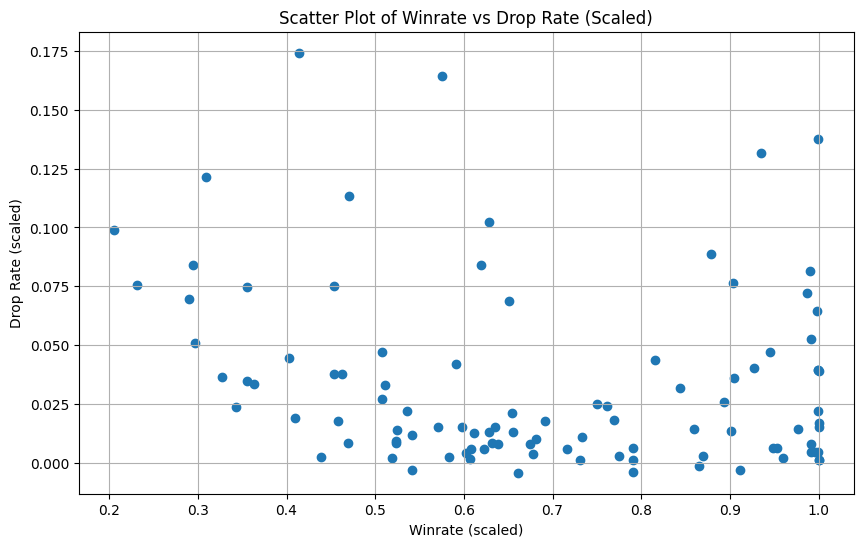

In [ ]:
# prompt: df: Vẽ scatter plot winrate và drop_rate (trước khi vẽ chia cả 2 cho 100)

# Scale winrate and drop_user
df['winrate_scaled'] = df['winrate'] / 100
df['drop_user_scaled'] = df['drop_user'] / 100
df2 = df[df['level'] <= 100]
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df2['winrate_scaled'], df2['drop_user_scaled'])
plt.xlabel('Winrate (scaled)')
plt.ylabel('Drop Rate (scaled)')
plt.title('Scatter Plot of Winrate vs Drop Rate (Scaled)')
plt.grid(True)
plt.show()

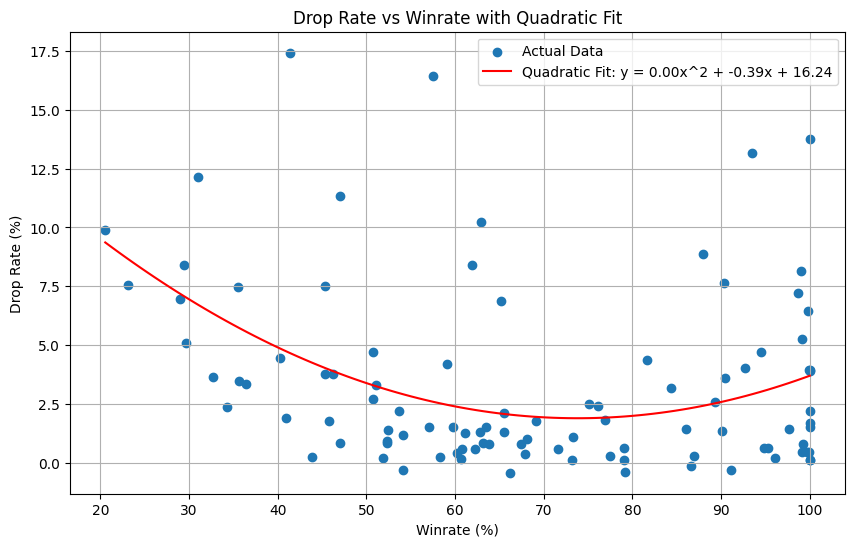

In [ ]:
# Lấy dữ liệu winrate và drop_user
x = df2['winrate']
y = df2['drop_user']

# Phù hợp với mô hình bậc 2
coeffs = np.polyfit(x, y, 2) # Tìm hệ số a, b, c cho phương trình bậc 2

# Tạo dữ liệu để vẽ đường cong hồi quy
x_curve = np.linspace(x.min(), x.max(), 100) # Tạo 100 điểm trong khoảng min-max của winrate
y_curve = coeffs[0] * x_curve**2 + coeffs[1] * x_curve + coeffs[2] # Tính drop rate dự đoán

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Actual Data')
plt.plot(x_curve, y_curve, color='red', label=f'Quadratic Fit: y = {coeffs[0]:.2f}x^2 + {coeffs[1]:.2f}x + {coeffs[2]:.2f}')

plt.xlabel('Winrate (%)')
plt.ylabel('Drop Rate (%)')
plt.title('Drop Rate vs Winrate with Quadratic Fit')
plt.legend()
plt.grid(True)
plt.show()

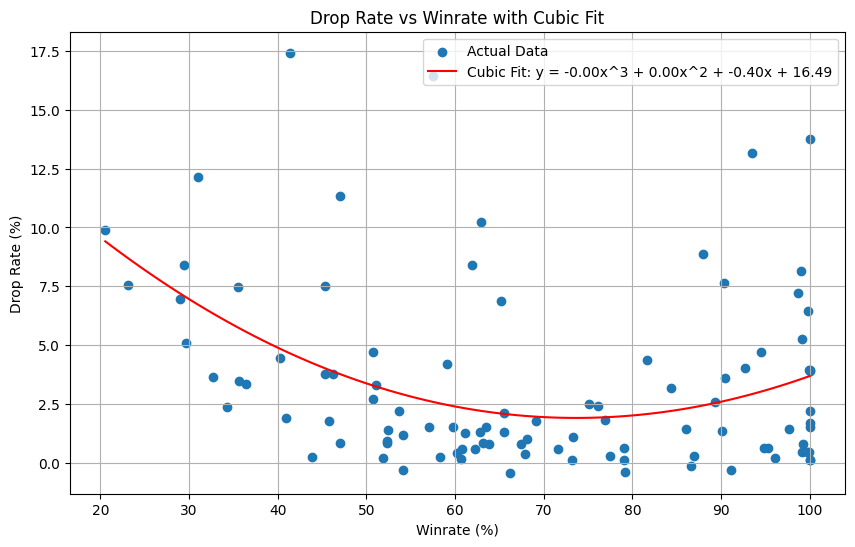

In [ ]:
# Lấy dữ liệu winrate và drop_user
x = df2['winrate']
y = df2['drop_user']

# Phù hợp với mô hình bậc 3
coeffs = np.polyfit(x, y, 3) # Tìm hệ số a, b, c, d cho phương trình bậc 3

# Tạo dữ liệu để vẽ đường cong hồi quy
x_curve = np.linspace(x.min(), x.max(), 100) # Tạo 100 điểm trong khoảng min-max của winrate
y_curve = coeffs[0] * x_curve**3 + coeffs[1] * x_curve**2 + coeffs[2] * x_curve + coeffs[3] # Tính drop rate dự đoán

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Actual Data')
plt.plot(x_curve, y_curve, color='red', label=f'Cubic Fit: y = {coeffs[0]:.2f}x^3 + {coeffs[1]:.2f}x^2 + {coeffs[2]:.2f}x + {coeffs[3]:.2f}')

plt.xlabel('Winrate (%)')
plt.ylabel('Drop Rate (%)')
plt.title('Drop Rate vs Winrate with Cubic Fit')
plt.legend()
plt.grid(True)
plt.show()

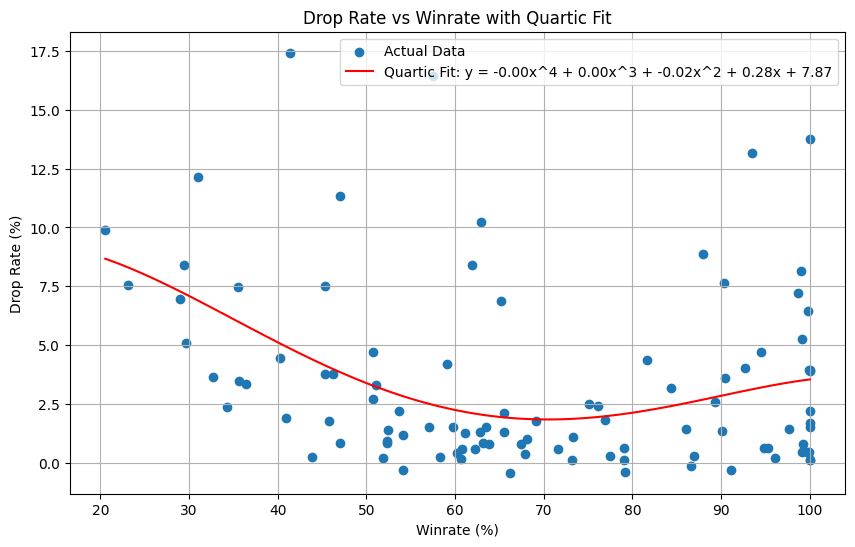

In [ ]:
# Lấy dữ liệu winrate và drop_user
x = df2['winrate']
y = df2['drop_user']

# Phù hợp với mô hình bậc 4
coeffs = np.polyfit(x, y, 4) # Tìm hệ số a, b, c, d, e cho phương trình bậc 4

# Tạo dữ liệu để vẽ đường cong hồi quy
x_curve = np.linspace(x.min(), x.max(), 100) # Tạo 100 điểm trong khoảng min-max của winrate
y_curve = coeffs[0] * x_curve**4 + coeffs[1] * x_curve**3 + coeffs[2] * x_curve**2 + coeffs[3] * x_curve + coeffs[4] # Tính drop rate dự đoán

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Actual Data')
plt.plot(x_curve, y_curve, color='red', label=f'Quartic Fit: y = {coeffs[0]:.2f}x^4 + {coeffs[1]:.2f}x^3 + {coeffs[2]:.2f}x^2 + {coeffs[3]:.2f}x + {coeffs[4]:.2f}')

plt.xlabel('Winrate (%)')
plt.ylabel('Drop Rate (%)')
plt.title('Drop Rate vs Winrate with Quartic Fit')
plt.legend()
plt.grid(True)
plt.show()

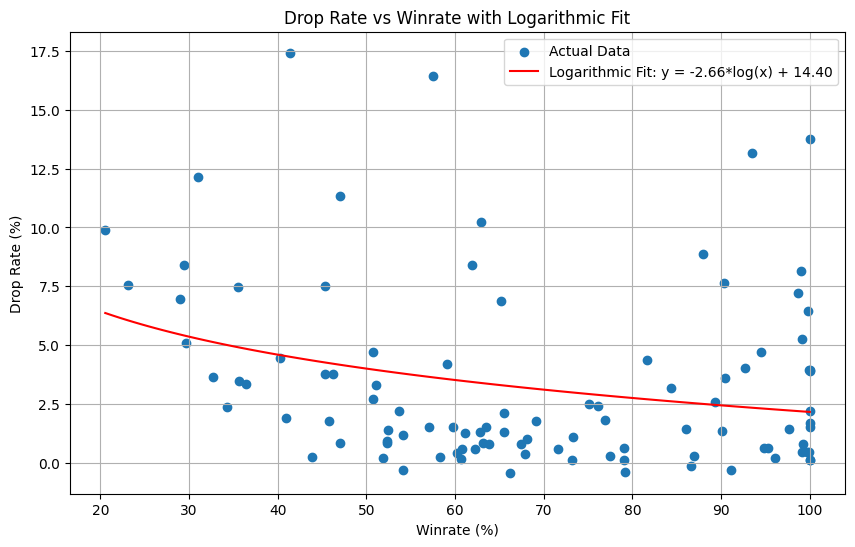

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Lấy dữ liệu winrate và drop_user
x = df2['winrate']
y = df2['drop_user']

# Định nghĩa hàm logarit để phù hợp
def log_func(x, a, b):
  return a * np.log(x) + b

# Phù hợp với mô hình logarit
# Sử dụng curve_fit để tìm các tham số a và b
try:
  coeffs, _ = curve_fit(log_func, x, y)
except RuntimeError as e:
  print(f"Could not fit log function: {e}")
  print("This might happen if winrate contains non-positive values.")
  coeffs = [0, 0] # Sử dụng giá trị mặc định nếu fitting thất bại

# Tạo dữ liệu để vẽ đường cong hồi quy
# Đảm bảo giá trị x_curve là dương
x_curve = np.linspace(x.min(), x.max(), 100)bn map
# Tránh log(0) hoặc log âm bằng cách chỉ lấy giá trị dương và thêm một số epsilon nhỏ nếu cần
x_curve = x_curve[x_curve > 0]
if x_curve.size == 0:
  print("No positive winrate values to plot log curve.")
  y_curve = []
else:
  y_curve = log_func(x_curve, *coeffs)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Actual Data')
if len(y_curve) > 0:
    plt.plot(x_curve, y_curve, color='red', label=f'Logarithmic Fit: y = {coeffs[0]:.2f}*log(x) + {coeffs[1]:.2f}')

plt.xlabel('Winrate (%)')
plt.ylabel('Drop Rate (%)')
plt.title('Drop Rate vs Winrate with Logarithmic Fit')
plt.legend()
plt.grid(True)
plt.show()

# Test

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250608' AND '20250610'
  and app_info.version in ('1.0.15', '1.0.16')
  and user_pseudo_id = '420c18cca4571dc2e56921b521aaa781'
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression', 'ads_reward_complete')
  and key in ('level', 'ad_format')
  and (ev.key = 'level'
  and COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)) = '86')
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()
sequence_user

user_pseudo_id    event_name   event_timestamp    key  \
0  420c18cca4571dc2e56921b521aaa781   start_level  1749549649721412  level   
1  420c18cca4571dc2e56921b521aaa781  revive_level  1749549759219436  level   
2  420c18cca4571dc2e56921b521aaa781     win_level  1749549791343450  level   

  value  
0    86  
1    86  
2    86

In [ ]:
sequence_user['event_timestamp2'] = pd.to_datetime(sequence_user['event_timestamp'], unit='us')
sequence_user

user_pseudo_id    event_name   event_timestamp    key  \
0  420c18cca4571dc2e56921b521aaa781   start_level  1749549649721412  level   
1  420c18cca4571dc2e56921b521aaa781  revive_level  1749549759219436  level   
2  420c18cca4571dc2e56921b521aaa781     win_level  1749549791343450  level   

  value           event_timestamp2  
0    86 2025-06-10 10:00:49.721412  
1    86 2025-06-10 10:02:39.219436  
2    86 2025-06-10 10:03:11.343450

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  event_timestamp,
  ev.key,
  COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)
  ) AS value
FROM
  `crazy-coffee-jam.analytics_483028617.events_intraday_*`,
  UNNEST(event_params) AS ev
WHERE
  _TABLE_SUFFIX BETWEEN '20250608' AND '20250610'
  and app_info.version in ('1.0.16')
  and user_pseudo_id = '0c5a9b28fbe892c2030ad3cb90a693ec'
  and event_name in ('first_open','start_level', 'win_level', 'lose_level', 'revive_level', 'booster_use', 'app_remove','ad_impression','win_level_time')
  and key in ('level', 'ad_format')
  and (ev.key = 'level'
  and COALESCE(ev.value.string_value,
           CAST(ev.value.int_value AS STRING),
           CAST(ev.value.float_value AS STRING),
           CAST(ev.value.double_value AS STRING)) in ('51'))
ORDER BY
  user_pseudo_id,
  event_timestamp
"""
sequence_user = client.query(query).to_dataframe()
sequence_user

user_pseudo_id      event_name   event_timestamp    key  \
0  0c5a9b28fbe892c2030ad3cb90a693ec     start_level  1749572678269158  level   
1  0c5a9b28fbe892c2030ad3cb90a693ec  win_level_time  1749572683359162  level   
2  0c5a9b28fbe892c2030ad3cb90a693ec       win_level  1749572685390165  level   

  value  
0    51  
1    51  
2    51

In [ ]:
sequence_user['event_timestamp2'] = pd.to_datetime(sequence_user['event_timestamp'], unit='us')
sequence_user

user_pseudo_id      event_name   event_timestamp    key  \
0  0c5a9b28fbe892c2030ad3cb90a693ec     start_level  1749572678269158  level   
1  0c5a9b28fbe892c2030ad3cb90a693ec  win_level_time  1749572683359162  level   
2  0c5a9b28fbe892c2030ad3cb90a693ec       win_level  1749572685390165  level   

  value           event_timestamp2  
0    51 2025-06-10 16:24:38.269158  
1    51 2025-06-10 16:24:43.359162  
2    51 2025-06-10 16:24:45.390165

In [ ]:
query = """
select * from `crazy-coffee-jam.dashboard_table.level_data`
where user_pseudo_id = '226513ae89d0abbd14bac897ca6667c1'
order by level, attempt_times asc
"""

check = client.query(query).to_dataframe()
check['event_start_level_timestamp'] = pd.to_datetime(check['event_start_level_timestamp'], unit='us')
check['event_end_level_timestamp'] = pd.to_datetime(check['event_end_level_timestamp'], unit='us')
check

event_date version                    user_pseudo_id  level  \
0   2025-05-12   1.0.7  226513ae89d0abbd14bac897ca6667c1      1   
1   2025-05-12   1.0.7  226513ae89d0abbd14bac897ca6667c1      2   
2   2025-05-12   1.0.7  226513ae89d0abbd14bac897ca6667c1      3   
3   2025-05-12   1.0.7  226513ae89d0abbd14bac897ca6667c1      4   
4   2025-05-12   1.0.7  226513ae89d0abbd14bac897ca6667c1      5   
..         ...     ...                               ...    ...   
60  2025-05-25  1.0.12  226513ae89d0abbd14bac897ca6667c1     40   
61  2025-05-25  1.0.12  226513ae89d0abbd14bac897ca6667c1     40   
62  2025-05-25  1.0.12  226513ae89d0abbd14bac897ca6667c1     40   
63  2025-05-25  1.0.12  226513ae89d0abbd14bac897ca6667c1     40   
64  2025-05-25  1.0.12  226513ae89d0abbd14bac897ca6667c1     40   

   event_start_level_timestamp  event_end_level_timestamp  attempt_times  \
0   2025-05-11 22:17:31.133095 2025-05-11 22:17:42.483703              1   
1   2025-05-11 22:17:42.483703 2025-05-11 22:17:52.120714              1   
2   2025-05-11 22:17:52.120714 2025-05-11 22:18:02.867722              1   
3   2025-05-11 22:18:02.867722 2025-05-11 22:18:27.940733              1   
4   2025-05-11 22:18:27.940733 2025-05-11 23:54:18.084546              1   
..                         ...                        ...            ...   
60  2025-05-25 14:32:33.269398 2025-05-25 14:37:04.141436              3   
61  2025-05-25 14:37:04.141436 2025-05-25 14:44:18.528496              4   
62  2025-05-25 14:44:18.528496 2025-05-25 14:57:42.150548              5   
63  2025-05-25 14:57:42.150548 2025-05-25 16:55:30.515798              6   
64  2025-05-25 16:55:30.515798                        NaT              7   

    booster_use  ad_rewards  revive  
0             0           0       0  
1             0           0       0  
2             0           0       0  
3             0           0       0  
4             0           0       0  
..          ...         ...     ...  
60            0           0       0  
61            0           0       0  
62            0           0       0  
63            0           0       0  
64            0           0       0  

[65 rows x 10 columns]